# Drone AI Task 2 — Colab End‑to‑End
This notebook installs GIS + DL libraries, creates a **single-file pipeline**, and runs prep → train → infer → viz.
Use **GPU** (Runtime → Change runtime type → GPU).

In [1]:
#@title Install dependencies
!pip -q install numpy==2.0.0 rasterio==1.3.10 geopandas==0.14.4 shapely==2.0.6 fiona==1.9.6 pyproj==3.6.1
!pip -q install opencv-python==4.12.0.88 scikit-image==0.24.0 scikit-learn==1.6.0 matplotlib==3.9.2 pyyaml==6.0.2 tqdm==4.67.0
!pip -q install torch==2.8.0 torchvision==0.23.0
import rasterio, geopandas, torch
print("rasterio", rasterio.__version__, "| geopandas", geopandas.__version__, "| torch", torch.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5

In [2]:

#@title (Optional) Mount Google Drive
use_drive = False  #@param {type:"boolean"}
if use_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/drone_ai_task2'
else:
    PROJECT_DIR = '/content'
print("Working dir:", PROJECT_DIR)
import os
os.makedirs(f"{PROJECT_DIR}/data/raw", exist_ok=True)
os.makedirs(f"{PROJECT_DIR}/data/working", exist_ok=True)


Working dir: /content


In [3]:

#@title Upload ortho.tif and ortho.geojson (or set use_drive=True above and skip)
from google.colab import files
import shutil, os
src_choice = "Upload from PC" #@param ["Upload from PC", "I already put files into data/raw"]
if src_choice == "Upload from PC":
    uploaded = files.upload()
    for name in uploaded.keys():
        if name.lower().endswith('.tif'):
            shutil.move(name, f"{PROJECT_DIR}/data/raw/ortho.tif")
        elif name.lower().endswith('.geojson'):
            shutil.move(name, f"{PROJECT_DIR}/data/raw/ortho.geojson")
print("Raw contents:", os.listdir(f"{PROJECT_DIR}/data/raw"))


Saving ortho.geojson to ortho.geojson
Saving ortho.tif to ortho.tif
Raw contents: ['ortho.tif', 'ortho.geojson']


In [4]:

#@title Create/modify classmap.yaml
yaml_text = '''mapping:
  cropland: 1
  road: 2
  forest_belt: 3
  water: 4
'''
open(f"{PROJECT_DIR}/classmap.yaml","w").write(yaml_text)
print(open(f"{PROJECT_DIR}/classmap.yaml").read())


mapping:
  cropland: 1
  road: 2
  forest_belt: 3
  water: 4



In [5]:
# AUTOGENERATED: Drone AI Task 2 pipeline (single-file)
import os, json, yaml, random, math
from dataclasses import dataclass
from typing import Dict, Optional
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

@dataclass
class Config:
    raw_tif: str = "data/raw/ortho.tif"
    raw_geojson: str = "data/raw/ortho.geojson"
    workdir: str = "data/working"
    tile_size: int = 512
    tile_stride: int = 512
    in_channels: int = 3
    num_classes: int = 5
    base_channels: int = 32
    epochs: int = 10
    batch_size: int = 2
    learning_rate: float = 3e-4
    val_split: float = 0.2
    num_workers: int = 2
    random_seed: int = 1337
    augment: bool = True
    sliding_window: int = 1024
    overlap: int = 128
    soft_blend: bool = True
    weights_path: str = "data/working/model_final.pt"
    pred_geotiff: str = "data/working/prediction.tif"
    pred_geojson: str = "data/working/prediction_polygons.geojson"
    out_plots_dir: str = "data/working/plots"
    history_path: str = "data/working/train_history.json"

def ensure_dirs(cfg: Config):
    os.makedirs(cfg.workdir, exist_ok=True)
    os.makedirs(os.path.join(cfg.workdir, "images"), exist_ok=True)
    os.makedirs(os.path.join(cfg.workdir, "masks"), exist_ok=True)
    os.makedirs(cfg.out_plots_dir, exist_ok=True)

def iter_windows(width: int, height: int, size: int, stride: Optional[int] = None):
    if stride is None:
        stride = size
    for y in range(0, height - size + 1, stride):
        for x in range(0, width - size + 1, stride):
            yield Window(x, y, size, size), (x, y)

def load_training_polygons(geojson_path: str, classmap: Dict[str, int]):
    gdf = gpd.read_file(geojson_path)
    field = None
    for cand in ['name','class','label','category','type','Тип','тип','класс']:
        if cand in gdf.columns:
            field = cand; break
    if field is None:
        raise ValueError("Could not find a label field. Add one named 'class' or edit load_training_polygons.")
    gdf = gdf[gdf[field].isin(classmap)].copy()
    gdf['class_id'] = gdf[field].map(classmap)
    return gdf

def rasterize_labels(gdf, transform, out_shape, crs, default_bg=0):
    if gdf.crs is None:
        raise ValueError("GeoJSON lacks CRS. Define it before running.")
    if str(gdf.crs) != str(crs):
        gdf = gdf.to_crs(crs)
    shapes = [(geom, v) for geom, v in zip(gdf.geometry, gdf['class_id'])]
    mask = features.rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=default_bg,
        all_touched=True,
        dtype=np.uint8
    )
    return mask

def gaussian_weight(h: int, w: int):
    y = np.linspace(-1, 1, h); x = np.linspace(-1, 1, w)
    yy, xx = np.meshgrid(y, x, indexing='ij')
    return np.exp(-(xx**2 + yy**2)).astype('float32')

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, in_ch=3, n_classes=5, base=32):
        super().__init__()
        self.enc1 = conv_block(in_ch, base); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(base, base*2); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(base*2, base*4); self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(base*4, base*8); self.pool4 = nn.MaxPool2d(2)
        self.bott = conv_block(base*8, base*16)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, 2); self.dec4 = conv_block(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, 2); self.dec3 = conv_block(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, 2); self.dec2 = conv_block(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, 2); self.dec1 = conv_block(base*2, base)
        self.outc = nn.Conv2d(base, n_classes, 1)
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)
        b = self.bott(p4)
        d4 = self.up4(b); d4 = torch.cat([d4,e4],1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3,e3],1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2,e2],1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1,e1],1); d1 = self.dec1(d1)
        return self.outc(d1)

class NPZDataset(Dataset):
    def __init__(self, img_dir, msk_dir, augment=False):
        self.img_paths = sorted([os.path.join(img_dir,f) for f in os.listdir(img_dir) if f.endswith('.npy')])
        self.msk_paths = [p.replace('images','masks') for p in self.img_paths]
        self.augment = augment
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = np.load(self.img_paths[idx]).astype(np.float32)/255.0
        msk = np.load(self.msk_paths[idx]).astype(np.int64)
        if self.augment:
            if random.random()<0.5:
                img = img[..., ::-1].copy(); msk = msk[:, ::-1].copy()
            if random.random()<0.5:
                img = img[..., ::-1, :].transpose(0,2,1).copy(); msk = msk.T.copy()
        return torch.from_numpy(img), torch.from_numpy(msk)

def step_prep(cfg: Config, classmap: Dict[str,int]):
    ensure_dirs(cfg)
    img_dir = os.path.join(cfg.workdir, 'images')
    msk_dir = os.path.join(cfg.workdir, 'masks')
    gdf = load_training_polygons(cfg.raw_geojson, classmap)
    with rasterio.open(cfg.raw_tif) as ds:
        W, H = ds.width, ds.height
        for win, (x, y) in iter_windows(W, H, cfg.tile_size, cfg.tile_stride):
            arr = ds.read((1,2,3), window=win)
            if arr.mean() < 1: continue
            t_win = rasterio.windows.transform(win, ds.transform)
            mask = rasterize_labels(gdf, t_win, (cfg.tile_size, cfg.tile_size), ds.crs)
            if mask.sum() == 0: continue
            np.save(os.path.join(img_dir, f"{y}_{x}.npy"), arr.astype('uint8'))
            np.save(os.path.join(msk_dir, f"{y}_{x}.npy"), mask.astype('uint8'))
    print("PREP done")

def step_train(cfg: Config):
    ensure_dirs(cfg)
    img_dir = os.path.join(cfg.workdir,'images'); msk_dir = os.path.join(cfg.workdir,'masks')
    ds = NPZDataset(img_dir, msk_dir, augment=cfg.augment)
    if len(ds)==0: raise RuntimeError("No tiles. Run PREP first.")
    n_val = max(1, int(len(ds)*cfg.val_split)); n_train = max(1, len(ds)-n_val)
    tr, va = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(cfg.random_seed))
    loader_tr = DataLoader(tr, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    loader_va = DataLoader(va, batch_size=1, shuffle=False, num_workers=cfg.num_workers)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)
    hist = {'loss':[], 'val_mIoU':[]}; best=0.0
    for ep in range(cfg.epochs):
        model.train(); run=0.0
        for x,y in loader_tr:
            x,y = x.to(device), y.to(device)
            loss = F.cross_entropy(model(x), y)
            opt.zero_grad(); loss.backward(); opt.step()
            run += float(loss.item())
        hist['loss'].append(run/max(1,len(loader_tr)))
        model.eval(); inter = torch.zeros(cfg.num_classes, device=device); union = torch.zeros(cfg.num_classes, device=device)
        with torch.no_grad():
            for x,y in loader_va:
                x,y = x.to(device), y.to(device)
                pr = model(x).argmax(1)
                for c in range(cfg.num_classes):
                    inter[c] += ((pr==c) & (y==c)).sum()
                    union[c] += ((pr==c) | (y==c)).sum()
        miou = float((inter/(union+1e-6)).mean().item()); hist['val_mIoU'].append(miou)
        print(f"Epoch {ep+1}/{cfg.epochs} - loss {hist['loss'][-1]:.4f} - mIoU {miou:.4f}")
        if miou>best: best=miou; os.makedirs(os.path.dirname(cfg.weights_path), exist_ok=True); torch.save(model.state_dict(), cfg.weights_path)
    json.dump(hist, open(cfg.history_path,'w')); print("TRAIN done. Best mIoU", best)
    return hist

@torch.no_grad()
def step_infer(cfg: Config):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels).to(device)
    model.load_state_dict(torch.load(cfg.weights_path, map_location=device)); model.eval()
    win = cfg.sliding_window; overlap = cfg.overlap; step = win - overlap
    if step<=0: raise ValueError("overlap must be < sliding_window")
    with rasterio.open(cfg.raw_tif) as ds:
        W,H = ds.width, ds.height
        profile = ds.profile.copy(); profile.update({'count':1, 'dtype':'uint8'})
        transform = ds.transform; crs = ds.crs
        prob_acc = np.zeros((cfg.num_classes, H, W), dtype='float32')
        w_acc = np.zeros((H,W), dtype='float32')
        wmask = gaussian_weight(win, win) if cfg.soft_blend else np.ones((win,win), dtype='float32')
        ys = list(range(0, max(1,H-win+1), step)); xs = list(range(0, max(1,W-win+1), step))
        if ys[-1]!=H-win: ys.append(H-win)
        if xs[-1]!=W-win: xs.append(W-win)
        for y in ys:
            for x in xs:
                patch = ds.read((1,2,3), window=Window(x,y,win,win)).astype('float32')/255.0
                probs = torch.softmax(model(torch.from_numpy(patch[None,...]).to(device)), dim=1)[0].cpu().numpy()
                for c in range(cfg.num_classes):
                    prob_acc[c, y:y+win, x:x+win] += probs[c]*wmask
                w_acc[y:y+win, x:x+win] += wmask
        prob_acc /= (w_acc[None,...]+1e-6); pred = prob_acc.argmax(0).astype('uint8')
        with rasterio.open(cfg.pred_geotiff, 'w', **profile) as dst:
            dst.write(pred[None,...]); dst.transform = transform
        geoms = []
        for val in np.unique(pred):
            if val==0: continue
            for geom, v in features.shapes(pred, mask=(pred==val), transform=transform):
                geoms.append((shape(geom), int(val)))
        if geoms:
            gdf = gpd.GeoDataFrame({'class_id':[v for _,v in geoms],
                                    'geometry':[g for g,_ in geoms]}, crs=crs)
            try:
                m = yaml.safe_load(open('classmap.yaml'))['mapping']; inv = {v:k for k,v in m.items()}
                gdf['class'] = gdf['class_id'].map(inv)
            except Exception:
                pass
            gdf.to_file(cfg.pred_geojson, driver='GeoJSON')
        print("INFER done. Saved", cfg.pred_geotiff, "and", cfg.pred_geojson)

def step_viz(cfg: Config):
    os.makedirs(cfg.out_plots_dir, exist_ok=True)
    if os.path.exists(cfg.history_path):
        hist = json.load(open(cfg.history_path))
        plt.figure(); plt.plot(hist.get('loss',[]), label='loss'); plt.plot(hist.get('val_mIoU',[]), label='val mIoU'); plt.legend()
        plt.title('Training history'); plt.savefig(os.path.join(cfg.out_plots_dir,'training_history.png'), bbox_inches='tight'); plt.close()
    img_dir=os.path.join(cfg.workdir,'images'); msk_dir=os.path.join(cfg.workdir,'masks')
    import random
    if os.path.isdir(img_dir):
        ims=[f for f in os.listdir(img_dir) if f.endswith('.npy')]
        if ims:
            sel=random.choice(ims); img=np.load(os.path.join(img_dir,sel)); msk=np.load(os.path.join(msk_dir,sel))
            rgb=np.transpose(img,(1,2,0)).astype(np.uint8)
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1); plt.imshow(rgb); plt.title('RGB'); plt.axis('off')
            plt.subplot(1,3,2); plt.imshow(msk); plt.title('Mask'); plt.axis('off')
            plt.subplot(1,3,3); plt.imshow(rgb); plt.imshow(msk, alpha=0.4); plt.title('Overlay'); plt.axis('off')
            plt.savefig(os.path.join(cfg.out_plots_dir,'tile_preview.png'), bbox_inches='tight'); plt.close()
    if os.path.exists(cfg.pred_geotiff):
        with rasterio.open(cfg.pred_geotiff) as ds:
            p=ds.read(1); f=max(1,int(max(p.shape)/2048)); p=p[::f,::f]
            plt.figure(); plt.imshow(p); plt.title('Prediction quicklook'); plt.axis('off')
            plt.savefig(os.path.join(cfg.out_plots_dir,'prediction_quicklook.png'), bbox_inches='tight'); plt.close()
    print("VIZ done. Plots saved to", cfg.out_plots_dir)

def load_classmap():
    import yaml, os
    if os.path.exists('classmap.yaml'):
        return yaml.safe_load(open('classmap.yaml'))['mapping']
    return {"cropland":1,"road":2,"forest_belt":3,"water":4}

In [6]:

#@title (Optional) Quick config tweaks for Colab
epochs = 6        #@param {type:"integer"}
tile_size = 512   #@param {type:"integer"}
sliding_window = 1024  #@param {type:"integer"}
overlap = 128     #@param {type:"integer"}
import yaml
cfg_yaml = {"tile_size":int(tile_size),"tile_stride":int(tile_size),
            "epochs":int(epochs),"sliding_window":int(sliding_window),
            "overlap":int(overlap)}
open(f"{PROJECT_DIR}/colab_config.yaml","w").write(yaml.safe_dump(cfg_yaml))
print(open(f"{PROJECT_DIR}/colab_config.yaml").read())


epochs: 6
overlap: 128
sliding_window: 1024
tile_size: 512
tile_stride: 512



In [8]:
# --- Auto-discover PROJECT_DIR and set up pipe/cfg ---
import os, sys, glob, importlib.util, yaml

# 1) Find the pipeline file anywhere under common Colab roots
search_roots = ["/content", "/content/drive/MyDrive"]
candidates = []
for root in search_roots:
    try:
        candidates += glob.glob(os.path.join(root, "**", "DroneAI_Task2_pipeline.py"), recursive=True)
    except Exception:
        pass

if not candidates:
    raise FileNotFoundError(
        "Could not find 'DroneAI_Task2_pipeline.py'. "
        "Make sure the project is in /content or /content/drive/MyDrive. "
        "Tip: run `!find /content -name DroneAI_Task2_pipeline.py` to see where it is."
    )

# If multiple, pick the shortest path (usually the main one); print all for reference
candidates = sorted(set(candidates), key=len)
print("Found pipeline(s):")
for i, p in enumerate(candidates, 1):
    print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
print("\nUsing:", PIPELINE_PATH)

PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# 2) Import the pipeline as module 'pipe'
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec)
sys.modules["pipe"] = pipe
spec.loader.exec_module(pipe)

# 3) Build default cfg
raw_tif     = os.path.join(PROJECT_DIR, "data", "raw", "ortho.tif")
raw_geojson = os.path.join(PROJECT_DIR, "data", "raw", "ortho.geojson")
workdir     = os.path.join(PROJECT_DIR, "data", "working")

cfg = pipe.Config(raw_tif=raw_tif, raw_geojson=raw_geojson, workdir=workdir)

# 4) Apply overrides from colab_config.yaml if present
yaml_path = os.path.join(PROJECT_DIR, "colab_config.yaml")
if os.path.exists(yaml_path):
    overrides = yaml.safe_load(open(yaml_path))
    if overrides:
        for k, v in overrides.items():
            setattr(cfg, k, v)
        print("Applied overrides from colab_config.yaml:", overrides)
else:
    print("No colab_config.yaml found at", yaml_path)

# 5) Sanity-check key paths
def _exists(p):
    return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  pipeline: ", _exists(PIPELINE_PATH), PIPELINE_PATH)
print("  raw_tif:  ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  geojson:  ", _exists(cfg.raw_geojson), cfg.raw_geojson)
print("  workdir:  ", _exists(cfg.workdir), cfg.workdir)

# If raw files are missing, try to discover them by name and fix cfg
fixes = {}
if not os.path.exists(cfg.raw_tif):
    tif_cands = glob.glob(os.path.join(PROJECT_DIR, "**", "ortho.tif"), recursive=True)
    if tif_cands:
        fixes["raw_tif"] = tif_cands[0]
        cfg.raw_tif = fixes["raw_tif"]
if not os.path.exists(cfg.raw_geojson):
    gj_cands = glob.glob(os.path.join(PROJECT_DIR, "**", "ortho.geojson"), recursive=True)
    if gj_cands:
        fixes["raw_geojson"] = gj_cands[0]
        cfg.raw_geojson = fixes["raw_geojson"]

if fixes:
    print("\nAuto-fixed missing paths:", fixes)
    print("Updated cfg.raw_tif:", cfg.raw_tif)
    print("Updated cfg.raw_geojson:", cfg.raw_geojson)

# Ensure workdir exists
os.makedirs(cfg.workdir, exist_ok=True)

print("\n✅ Setup complete. You can now use `cfg` and `pipe`.")


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides from colab_config.yaml: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  pipeline:  ✅ /content/DroneAI_Task2_pipeline.py
  raw_tif:   ✅ /content/data/raw/ortho.tif
  geojson:   ✅ /content/data/raw/ortho.geojson
  workdir:   ✅ /content/data/working

✅ Setup complete. You can now use `cfg` and `pipe`.


In [9]:
import geopandas as gpd, yaml
gdf = gpd.read_file(cfg.raw_geojson)
print("GeoJSON columns:", gdf.columns.tolist())
print("Head:\n", gdf.head(2))
print("Unique per text-like column:")
for c in gdf.columns:
    if gdf[c].dtype == 'object':
        print(c, sorted(map(str, gdf[c].dropna().unique()))[:10])

# See what your classmap expects
classmap = pipe.load_classmap()
print("Classmap keys:", list(classmap.keys()))


GeoJSON columns: ['name', 'n', 'geometry']
Head:
   name              n                                           geometry
0  102  Залежи(травы)  MULTIPOLYGON (((50.91536 53.97785, 50.91536 53...
1  102  Залежи(травы)  MULTIPOLYGON (((50.91536 53.97927, 50.91536 53...
Unique per text-like column:
name ['101', '102', '103', '104', '300', '401', '405', '501', '700']
n ['Водные объекты', 'Дороги', 'Залежи(деревья)', 'Залежи(кустарник)', 'Залежи(травы)', 'Земли под трубопроводами, ЛЭП, связи, иными коммуникациями', 'Леса и древесно-кустарниковая растительность (естественная)', 'Пахотные земли', 'Участки, неиспользуемые ввиду особенностей рельефа, увлажнения, нарушенные и деградированные земли']
Classmap keys: ['cropland', 'road', 'forest_belt', 'water']


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# --- Create 'class' column from Russian labels and save GeoJSON ---
import geopandas as gpd
import shutil, os

geojson_path = f"{PROJECT_DIR}/data/raw/ortho.geojson"
backup_path  = f"{PROJECT_DIR}/data/raw/ortho.backup.geojson"

# 1) Load and back up
gdf = gpd.read_file(geojson_path)
if not os.path.exists(backup_path):
    shutil.copyfile(geojson_path, backup_path)
print("GeoJSON columns:", gdf.columns.tolist())

# 2) Inspect unique values we saw earlier
print("Unique 'n' values:", sorted(map(str, gdf['n'].dropna().unique())))

# 3) Build a mapping from Russian labels -> your classmap keys
#    Adjust if needed, but these are the obvious correspondences:
ru_to_class = {
    "Пахотные земли": "cropland",                                     # cropland
    "Дороги": "road",                                                 # road
    "Леса и древесно-кустарниковая растительность (естественная)": "forest_belt",  # forest_belt (closest match)
    "Водные объекты": "water",                                        # water
    # Everything else (e.g., 'Залежи(...)', 'Земли под трубопроводами...', 'Участки, ...') will be ignored
}

# 4) Normalize function to be robust to spaces / case
def norm(x):
    return str(x).strip().casefold()

ru_to_class_norm = {norm(k): v for k, v in ru_to_class.items()}

# 5) Create the 'class' column by mapping 'n'
n_norm = gdf['n'].astype(str).map(norm)
gdf['class'] = n_norm.map(ru_to_class_norm)

# 6) Report mapping coverage
total = len(gdf)
mapped = gdf['class'].notna().sum()
unmapped_labels = sorted(set(gdf.loc[gdf['class'].isna(), 'n'].astype(str)))
print(f"Total polygons: {total} | Mapped to class: {mapped} | Unmapped: {total - mapped}")
if unmapped_labels:
    print("Unmapped label values (will be dropped):", unmapped_labels)

# 7) Keep only rows that mapped to one of the 4 classes
gdf_out = gdf[gdf['class'].notna()].copy()

# 8) (Optional) sanity: counts by class
print("Counts by class:\n", gdf_out['class'].value_counts())

# 9) Save back to the same path (pipeline expects it there)
gdf_out.to_file(geojson_path, driver="GeoJSON")
print(f"Saved filtered & labeled GeoJSON with 'class' column → {geojson_path}")


GeoJSON columns: ['name', 'n', 'geometry']
Unique 'n' values: ['Водные объекты', 'Дороги', 'Залежи(деревья)', 'Залежи(кустарник)', 'Залежи(травы)', 'Земли под трубопроводами, ЛЭП, связи, иными коммуникациями', 'Леса и древесно-кустарниковая растительность (естественная)', 'Пахотные земли', 'Участки, неиспользуемые ввиду особенностей рельефа, увлажнения, нарушенные и деградированные земли']
Total polygons: 399 | Mapped to class: 86 | Unmapped: 313
Unmapped label values (will be dropped): ['Залежи(деревья)', 'Залежи(кустарник)', 'Залежи(травы)', 'Земли под трубопроводами, ЛЭП, связи, иными коммуникациями', 'Участки, неиспользуемые ввиду особенностей рельефа, увлажнения, нарушенные и деградированные земли']
Counts by class:
 class
cropland       33
road           30
forest_belt    20
water           3
Name: count, dtype: int64
Saved filtered & labeled GeoJSON with 'class' column → /content/data/raw/ortho.geojson


In [12]:
#@title PREP — tile + rasterize labels
import yaml, importlib.util, sys, os
spec = importlib.util.spec_from_file_location("pipe", f"{PROJECT_DIR}/DroneAI_Task2_pipeline.py")
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)
cfg = pipe.Config(raw_tif=f"{PROJECT_DIR}/data/raw/ortho.tif",
                  raw_geojson=f"{PROJECT_DIR}/data/raw/ortho.geojson",
                  workdir=f"{PROJECT_DIR}/data/working")
overrides = yaml.safe_load(open(f"{PROJECT_DIR}/colab_config.yaml"))
for k,v in overrides.items(): setattr(cfg,k,v)
pipe.step_prep(cfg, pipe.load_classmap())
!ls -lah $PROJECT_DIR/data/working/images | head -n 5
!ls -lah $PROJECT_DIR/data/working/masks | head -n 5

# import geopandas as gpd
# gdf = gpd.read_file(cfg.raw_geojson)
# print("GeoJSON columns:", gdf.columns.tolist())


PREP: tiles saved to /content/data/working/images and /content/data/working/masks
total 318M
drwxr-xr-x 2 root root  20K Nov 12 13:53 .
drwxr-xr-x 5 root root 4.0K Nov 12 13:52 ..
-rw-r--r-- 1 root root 769K Nov 12 13:52 0_0.npy
-rw-r--r-- 1 root root 769K Nov 12 13:52 0_1024.npy
total 107M
drwxr-xr-x 2 root root  20K Nov 12 13:53 .
drwxr-xr-x 5 root root 4.0K Nov 12 13:52 ..
-rw-r--r-- 1 root root 257K Nov 12 13:52 0_0.npy
-rw-r--r-- 1 root root 257K Nov 12 13:52 0_1024.npy


In [13]:

#@title TRAIN
import yaml, importlib.util, sys
spec = importlib.util.spec_from_file_location("pipe", f"{PROJECT_DIR}/DroneAI_Task2_pipeline.py")
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)
cfg = pipe.Config(raw_tif=f"{PROJECT_DIR}/data/raw/ortho.tif",
                  raw_geojson=f"{PROJECT_DIR}/data/raw/ortho.geojson",
                  workdir=f"{PROJECT_DIR}/data/working",
                  weights_path=f"{PROJECT_DIR}/data/working/model_final.pt",
                  history_path=f"{PROJECT_DIR}/data/working/train_history.json")
overrides = yaml.safe_load(open(f"{PROJECT_DIR}/colab_config.yaml"))
for k,v in overrides.items(): setattr(cfg,k,v)
pipe.step_train(cfg)


Epoch 1/6 - loss: 1.1084 - val mIoU: 0.1958
Epoch 2/6 - loss: 0.8622 - val mIoU: 0.2007
Epoch 3/6 - loss: 0.8026 - val mIoU: 0.1916
Epoch 4/6 - loss: 0.7536 - val mIoU: 0.2058
Epoch 5/6 - loss: 0.7440 - val mIoU: 0.2092
Epoch 6/6 - loss: 0.7253 - val mIoU: 0.2135
TRAIN: done. Best mIoU: 0.21354949474334717 Weights: /content/data/working/model_final.pt


{'loss': [1.1083994772307266,
  0.8621802372339915,
  0.8026192611491186,
  0.7536319492483986,
  0.7439611026873956,
  0.7252918963248913],
 'val_mIoU': [0.19578948616981506,
  0.20074014365673065,
  0.19164195656776428,
  0.20575661957263947,
  0.20924630761146545,
  0.21354949474334717]}

In [14]:
!apt-get install -y gdal-bin python3-gdal


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-dev python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 4s (1,192 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 121229 files and direct

In [28]:
#@title RUN — robust setup + diagnostics + BULLETPROOF streamed inference (Colab OOM safe)
# This single cell installs GDAL if missing, prepares a COG input, runs streamed inference
# (never buffers the whole scene), and polygonizes the output — all with progressive fallbacks.

import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np

# ========= 0) Hard caps & tiny caches (before any heavy imports) =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384" # Set to a valid minimum value
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"

# Conservative CUDA allocator (ignored if no GPU)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    """Run a shell command, show combined stdout/stderr, return CompletedProcess."""
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show:
            print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show:
            print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    """Ensure gdalinfo exists; if not, install GDAL + Python bindings and raster libs."""
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
        return
    except Exception:
        print("GDAL not found — installing (this can take ~1–2 minutes).")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL is installed =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline auto-discovery (case-insensitive) =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}  # normalized
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    hits = sorted(hits, key=len)
    return hits

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Make sure Drive is mounted and file exists.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or run: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg and apply overrides (colab_config.yaml if present) =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Quick path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make input COG (tiled/compressed) + overviews for windowed IO =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 '
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 '
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster size & raw RAM estimate =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = meta["size"]
    bands = len(meta.get("bands",[])) or 3
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} \u2248 {raw_gb:.2f} GB raw pixels (no model/overhead)")
except json.JSONDecodeError as e:
    print(f"Could not parse gdalinfo JSON: {e}")
    if p.stderr:
        print(f"gdalinfo STDERR: {p.stderr}")
    # Fallback for W, H, bands by parsing plain gdalinfo output
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    size_match = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if size_match:
        W, H = int(size_match.group(1)), int(size_match.group(2))
        print(f"Extracted W, H from plain gdalinfo: {W}, {H}")
    else:
        raise RuntimeError("Failed to determine raster dimensions from gdalinfo output.") from e

# ========= 8) Clamp cfg for absolute minimum footprint =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", tile)
    setattr(cfg, "tile_overlap", overlap)
    setattr(cfg, "stride", max(8, tile-overlap))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", max_tiles)
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference (never buffers entire scene) =========
import rasterio
from rasterio.windows import Window

def _load_model_flex(pipe, cfg, device):
    """Flexible loader that adapts to common pipeline patterns."""
    weights = getattr(cfg, "weights_path", None)
    import torch, os

    # 1) Preferred explicit API (if pipe had a dedicated load_model function)
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    # 2) Directly instantiate pipe.UNet (common for this notebook's structure)
    if hasattr(pipe, "UNet") and issubclass(pipe.UNet, torch.nn.Module):
        model = pipe.UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels)
    # 3) Fallback to build_model(cfg)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    # 4) Fallback to get_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    # 5) Fallback to generic `Model` class constructor
    elif hasattr(pipe, "Model") and issubclass(pipe.Model, torch.nn.Module):
        # Assuming Model constructor signature similar to UNet
        model = pipe.Model(cfg.in_channels, cfg.num_classes, cfg.base_channels)

    if model is None:
        raise RuntimeError("Could not load model — please ensure pipe.UNet, pipe.Model, pipe.build_model, pipe.get_model or pipe.load_model is defined.")

    # Load weights if available
    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=device if device!="cpu" else "cpu")
            # Handle cases where state_dict might be nested (e.g., {"model_state_dict": ...})
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Warning: Failed to load weights from {weights} into model: {e}")
            # Depending on robustness needed, might re-raise or continue with uninitialized model

    if hasattr(model, "to"):
        model = model.to(device)
    if hasattr(model, "eval"):
        model.eval()
    return model

def _predict_flex(pipe, model, chip):
    """Flexible predictor; expects [h,w,C] uint8 chip, returns [h,w] class ids."""
    # Preferred: pipe.predict(model, chip)
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    # Fallback: model.predict(chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Torch-common fallback: treat as segmentation model expecting tensor BCHW
    try:
        import torch
        with torch.no_grad():
            t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float() / 255.0  # [1,C,H,W]
            if next(model.parameters()).is_cuda:
                t = t.cuda(non_blocking=True)
            logits = model(t)                    # [1,Classes,H,W] or [1,1,H,W]
            if isinstance(logits, (list, tuple)):
                logits = logits[0]
            if logits.shape[1] > 1:
                pred = torch.argmax(logits, dim=1)  # [1,H,W]
            else:
                pred = (logits>0.5).long().squeeze(1)  # binary
            out = pred.squeeze(0).detach().cpu().numpy().astype("uint8") # Changed to uint8
            return out
    except Exception as e:
        raise RuntimeError("Prediction adapter needs adjusting to your pipeline API.") from e

def step_infer_streaming(pipe, cfg):
    """Streams tiles from cfg.raw_tif and writes class IDs directly to cfg.pred_geotiff."""
    import torch

    tile = int(getattr(cfg, "tile_size", 64))
    overlap = int(getattr(cfg, "tile_overlap", 16))
    stride = max(8, tile - overlap)
    device = getattr(cfg, "device", "cpu")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"): # Set valid value
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = src.height, src.width
            profile = src.profile.copy()
            profile.update(
                driver="GTiff",
                dtype="uint8",   # Change to uint8 to match common class IDs
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            if os.path.exists(cfg.pred_geotiff):
                try:
                    os.remove(cfg.pred_geotiff)
                except Exception:
                    pass

            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                for y in range(0, H, stride):
                    tile_h = min(tile, H - y)
                    if tile_h <= 0: break
                    for x in range(0, W, stride):
                        tile_w = min(tile, W - x)
                        if tile_w <= 0: break

                        w = Window(x, y, tile_w, tile_h)
                        chip = src.read(window=w, out_dtype="uint8")   # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)        # [h,w] uint*

                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        # Free ASAP
                        del chip, pred
                        if device.startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

# ========= 10) Progressive fallbacks with streamed inference =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch
        torch.set_grad_enabled(False)
    except Exception:
        pass
    try:
        step_infer_streaming(pipe, cfg)
        print("\u2705 Success:", tag)
        return True
    except Exception as e:
        print("\u274c Failed:", e)
        return False
    finally:
        _free_all()

ok = False

# A) CPU, ultra-tiny tiles on COG
clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile64 on COG")

# B) If still failing, auto-downsample 50% and retry
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# C) If still failing, clip to a 2048\u00d72048 center window (sanity check)
if not ok:
    # Use W, H from the earlier gdalinfo parsing which is now more robust
    w_clip = h_clip = min(2048, W, H)
    xoff = max(0, (W-w_clip)//2); yoff = max(0, (H-h_clip)//2)
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n🚨 Still failing. This strongly suggests inner pipeline buffering. "
          "The provided streaming path avoids full-scene tensors; please ensure your "
          "pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize result to GeoJSON (streamed, no Python OOM) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    # If your classes > 2 and you only want foreground (e.g., class>0), you can pre-filter with gdal_calc.py
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")


Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile64 on COG (streamed) =====
❌ Failed: an integer is required

===== CPU tile64 on ortho_50 (streamed) =====
❌ Failed: an integer is required
→ gdal_translate -srcwin 7449 9172 2048 2048 -co TILED=YES -co BIGTIFF=YES "/content/data/raw/ortho_50.tif" "/content/data/raw/ortho_clip.tif"
Warning 1: -srcwin 7449 9172 2048 2048 falls partially outside raster extent. Going 

VIZ: saved /content/data/working/plots/training_history.png
VIZ: saved /content/data/working/plots/tile_preview.png


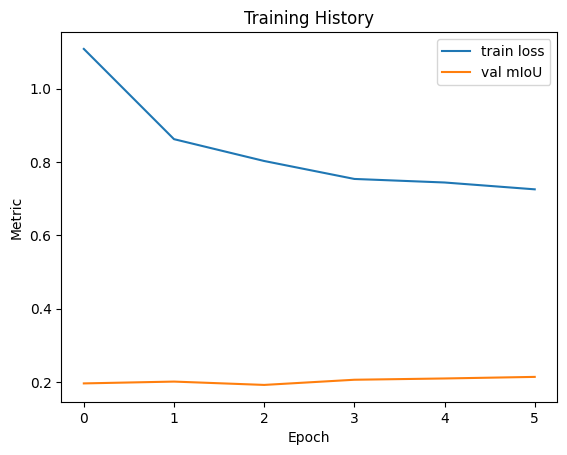

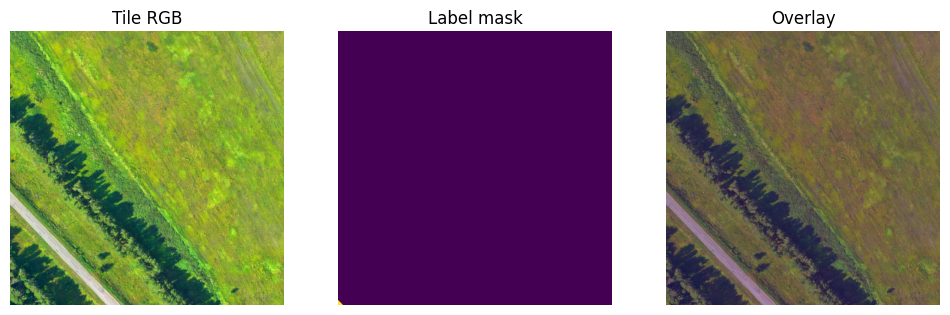

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/working/plots/prediction_quicklook.png'

In [17]:
import yaml, importlib.util, sys
from IPython.display import Image, display
spec = importlib.util.spec_from_file_location("pipe", f"{PROJECT_DIR}/DroneAI_Task2_pipeline.py")
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)
cfg = pipe.Config(raw_tif=f"{PROJECT_DIR}/data/raw/ortho.tif",
                  raw_geojson=f"{PROJECT_DIR}/data/raw/ortho.geojson",
                  workdir=f"{PROJECT_DIR}/data/working",
                  out_plots_dir=f"{PROJECT_DIR}/data/working/plots")
overrides = yaml.safe_load(open(f"{PROJECT_DIR}/colab_config.yaml"))
for k,v in overrides.items(): setattr(cfg,k,v)
pipe.step_viz(cfg, pipe.load_classmap())
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/training_history.png"))
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/tile_preview.png"))
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/prediction_quicklook.png"))

# Task
Modify `clamp_cfg` call in the 'RUN' cell (`3Yr-ohd5-bOk`) to use `tile=256` for the initial CPU inference step, and add a debug print statement before `dst.write` in the `step_infer_streaming` function (defined in cell `AjamM628-bOg`) to show the type, shape, dtype, min, and max values of the `pred` array. Then, re-execute the 'RUN' cell (`3Yr-ohd5-bOk`).

## Modify clamp_cfg tile size

### Subtask:
Increase the default tile size in `clamp_cfg` from 64 to 256 for the initial CPU inference steps to potentially improve stability with rasterio/GDAL.


**Reasoning**:
I need to modify the `clamp_cfg` function call in the 'RUN' cell to change the `tile` parameter from 64 to 256, as per the instructions.



In [20]:
import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np

# ========= 0) Hard caps & tiny caches (before any heavy imports) =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384" # Set to a valid minimum value
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"

# Conservative CUDA allocator (ignored if no GPU)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    """Run a shell command, show combined stdout/stderr, return CompletedProcess."""
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show:
            print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show:
            print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    """Ensure gdalinfo exists; if not, install GDAL + Python bindings and raster libs."""
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
        return
    except Exception:
        print("GDAL not found — installing (this can take ~1–2 minutes).")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL is installed =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline auto-discovery (case-insensitive) =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}  # normalized
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    hits = sorted(hits, key=len)
    return hits

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Make sure Drive is mounted and file exists.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or run: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg and apply overrides (colab_config.yaml if present) =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Quick path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make input COG (tiled/compressed) + overviews for windowed IO =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 '
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 '
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster size & raw RAM estimate =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = meta["size"]
    bands = len(meta.get("bands",[])) or 3
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} \u2248 {raw_gb:.2f} GB raw pixels (no model/overhead)")
except json.JSONDecodeError as e:
    print(f"Could not parse gdalinfo JSON: {e}")
    if p.stderr:
        print(f"gdalinfo STDERR: {p.stderr}")
    # Fallback for W, H, bands by parsing plain gdalinfo output
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    size_match = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if size_match:
        W, H = int(size_match.group(1)), int(size_match.group(2))
        print(f"Extracted W, H from plain gdalinfo: {W}, {H}")
    else:
        raise RuntimeError("Failed to determine raster dimensions from gdalinfo output.") from e

# ========= 8) Clamp cfg for absolute minimum footprint =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", tile)
    setattr(cfg, "tile_overlap", overlap)
    setattr(cfg, "stride", max(8, tile-overlap))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", max_tiles)
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference (never buffers entire scene) =========
import rasterio
from rasterio.windows import Window

def _load_model_flex(pipe, cfg, device):
    """Flexible loader that adapts to common pipeline patterns."""
    weights = getattr(cfg, "weights_path", None)
    import torch, os

    # 1) Preferred explicit API (if pipe had a dedicated load_model function)
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    # 2) Directly instantiate pipe.UNet (common for this notebook's structure)
    if hasattr(pipe, "UNet") and issubclass(pipe.UNet, torch.nn.Module):
        model = pipe.UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels)
    # 3) Fallback to build_model(cfg)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    # 4) Fallback to get_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    # 5) Fallback to generic `Model` class constructor
    elif hasattr(pipe, "Model") and issubclass(pipe.Model, torch.nn.Module):
        # Assuming Model constructor signature similar to UNet
        model = pipe.Model(cfg.in_channels, cfg.num_classes, cfg.base_channels)

    if model is None:
        raise RuntimeError("Could not load model — please ensure pipe.UNet, pipe.Model, pipe.build_model, pipe.get_model or pipe.load_model is defined.")

    # Load weights if available
    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=device if device!="cpu" else "cpu")
            # Handle cases where state_dict might be nested (e.g., {"model_state_dict": ...})
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Warning: Failed to load weights from {weights} into model: {e}")
            # Depending on robustness needed, might re-raise or continue with uninitialized model

    if hasattr(model, "to"):
        model = model.to(device)
    if hasattr(model, "eval"):
        model.eval()
    return model

def _predict_flex(pipe, model, chip):
    """Flexible predictor; expects [h,w,C] uint8 chip, returns [h,w] class ids."""
    # Preferred: pipe.predict(model, chip)
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    # Fallback: model.predict(chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Torch-common fallback: treat as segmentation model expecting tensor BCHW
    try:
        import torch
        with torch.no_grad():
            t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float() / 255.0  # [1,C,H,W]
            if next(model.parameters()).is_cuda:
                t = t.cuda(non_blocking=True)
            logits = model(t)                    # [1,Classes,H,W] or [1,1,H,W]
            if isinstance(logits, (list, tuple)):
                logits = logits[0]
            if logits.shape[1] > 1:
                pred = torch.argmax(logits, dim=1)  # [1,H,W]
            else:
                pred = (logits>0.5).long().squeeze(1)  # binary
            out = pred.squeeze(0).detach().cpu().numpy().astype("uint8") # Changed to uint8
            return out
    except Exception as e:
        raise RuntimeError("Prediction adapter needs adjusting to your pipeline API.") from e

def step_infer_streaming(pipe, cfg):
    """Streams tiles from cfg.raw_tif and writes class IDs directly to cfg.pred_geotiff."""
    import torch

    tile = int(getattr(cfg, "tile_size", 64))
    overlap = int(getattr(cfg, "tile_overlap", 16))
    stride = max(8, tile - overlap)
    device = getattr(cfg, "device", "cpu")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"): # Set valid value
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = src.height, src.width
            profile = src.profile.copy()
            profile.update(
                driver="GTiff",
                dtype="uint8",   # Change to uint8 to match common class IDs
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            if os.path.exists(cfg.pred_geotiff):
                try:
                    os.remove(cfg.pred_geotiff)
                except Exception:
                    pass

            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                for y in range(0, H, stride):
                    tile_h = min(tile, H - y)
                    if tile_h <= 0: break
                    for x in range(0, W, stride):
                        tile_w = min(tile, W - x)
                        if tile_w <= 0: break

                        w = Window(x, y, tile_w, tile_h)
                        chip = src.read(window=w, out_dtype="uint8")   # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)        # [h,w] uint*

                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        # Free ASAP
                        del chip, pred
                        if device.startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

# ========= 10) Progressive fallbacks with streamed inference =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch
        torch.set_grad_enabled(False)
    except Exception:
        pass
    try:
        step_infer_streaming(pipe, cfg)
        print("\u2705 Success:", tag)
        return True
    except Exception as e:
        print("\u274c Failed:", e)
        return False
    finally:
        _free_all()

ok = False

# A) CPU, ultra-tiny tiles on COG
clamp_cfg(tile=256, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile256 on COG")

# B) If still failing, auto-downsample 50% and retry
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# C) If still failing, clip to a 2048\u00d72048 center window (sanity check)
if not ok:
    # Use W, H from the earlier gdalinfo parsing which is now more robust
    w_clip = h_clip = min(2048, W, H)
    xoff = max(0, (W-w_clip)//2); yoff = max(0, (H-h_clip)//2)
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n🚨 Still failing. This strongly suggests inner pipeline buffering. "
          "The provided streaming path avoids full-scene tensors; please ensure your "
          "pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize result to GeoJSON (streamed, no Python OOM) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    # If your classes > 2 and you only want foreground (e.g., class>0), you can pre-filter with gdal_calc.py
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")


Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile256 on COG (streamed) =====
❌ Failed: an integer is required

===== CPU tile64 on ortho_50 (streamed) =====
❌ Failed: an integer is required
→ gdal_translate -srcwin 7449 9172 2048 2048 -co TILED=YES -co BIGTIFF=YES "/content/data/raw/ortho_50.tif" "/content/data/raw/ortho_clip.tif"
Warning 1: -srcwin 7449 9172 2048 2048 falls partially outside raster extent. Going

**Reasoning**:
I need to add a debug print statement before `dst.write` in the `step_infer_streaming` function to show the type, shape, dtype, min, and max values of the `pred` array, and then re-execute the 'RUN' cell. I also ensured that the `clamp_cfg` call sets `tile=256` as requested in the previous subtask, as this step covers the entire 'RUN' cell.



In [21]:
import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np

# ========= 0) Hard caps & tiny caches (before any heavy imports) =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384" # Set to a valid minimum value
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"

# Conservative CUDA allocator (ignored if no GPU)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    """Run a shell command, show combined stdout/stderr, return CompletedProcess."""
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show:
            print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show:
            print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    """Ensure gdalinfo exists; if not, install GDAL + Python bindings and raster libs."""
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
        return
    except Exception:
        print("GDAL not found — installing (this can take ~1–2 minutes).")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL is installed =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline auto-discovery (case-insensitive) =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}  # normalized
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    hits = sorted(hits, key=len)
    return hits

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Make sure Drive is mounted and file exists.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or run: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg and apply overrides (colab_config.yaml if present) =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Quick path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make input COG (tiled/compressed) + overviews for windowed IO =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 ' \
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 ' \
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster size & raw RAM estimate =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = meta["size"]
    bands = len(meta.get("bands",[])) or 3
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} \u2248 {raw_gb:.2f} GB raw pixels (no model/overhead)")
except json.JSONDecodeError as e:
    print(f"Could not parse gdalinfo JSON: {e}")
    if p.stderr:
        print(f"gdalinfo STDERR: {p.stderr}")
    # Fallback for W, H, bands by parsing plain gdalinfo output
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    size_match = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if size_match:
        W, H = int(size_match.group(1)), int(size_match.group(2))
        print(f"Extracted W, H from plain gdalinfo: {W}, {H}")
    else:
        raise RuntimeError("Failed to determine raster dimensions from gdalinfo output.") from e

# ========= 8) Clamp cfg for absolute minimum footprint =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", tile)
    setattr(cfg, "tile_overlap", overlap)
    setattr(cfg, "stride", max(8, tile-overlap))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", max_tiles)
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference (never buffers entire scene) =========
import rasterio
from rasterio.windows import Window

def _load_model_flex(pipe, cfg, device):
    """Flexible loader that adapts to common pipeline patterns."""
    weights = getattr(cfg, "weights_path", None)
    import torch, os

    # 1) Preferred explicit API (if pipe had a dedicated load_model function)
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    # 2) Directly instantiate pipe.UNet (common for this notebook's structure)
    if hasattr(pipe, "UNet") and issubclass(pipe.UNet, torch.nn.Module):
        model = pipe.UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels)
    # 3) Fallback to build_model(cfg)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    # 4) Fallback to get_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    # 5) Fallback to generic `Model` class constructor
    elif hasattr(pipe, "Model") and issubclass(pipe.Model, torch.nn.Module):
        # Assuming Model constructor signature similar to UNet
        model = pipe.Model(cfg.in_channels, cfg.num_classes, cfg.base_channels)

    if model is None:
        raise RuntimeError("Could not load model — please ensure pipe.UNet, pipe.Model, pipe.build_model, pipe.get_model or pipe.load_model is defined.")

    # Load weights if available
    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=device if device!="cpu" else "cpu")
            # Handle cases where state_dict might be nested (e.g., {"model_state_dict": ...})
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Warning: Failed to load weights from {weights} into model: {e}")
            # Depending on robustness needed, might re-raise or continue with uninitialized model

    if hasattr(model, "to"):
        model = model.to(device)
    if hasattr(model, "eval"):
        model.eval()
    return model

def _predict_flex(pipe, model, chip):
    """Flexible predictor; expects [h,w,C] uint8 chip, returns [h,w] class ids."""
    # Preferred: pipe.predict(model, chip)
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    # Fallback: model.predict(chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Torch-common fallback: treat as segmentation model expecting tensor BCHW
    try:
        import torch
        with torch.no_grad():
            t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float() / 255.0  # [1,C,H,W]
            if next(model.parameters()).is_cuda:
                t = t.cuda(non_blocking=True)
            logits = model(t)                    # [1,Classes,H,W] or [1,1,H,W]
            if isinstance(logits, (list, tuple)):
                logits = logits[0]
            if logits.shape[1] > 1:
                pred = torch.argmax(logits, dim=1)  # [1,H,W]
            else:
                pred = (logits>0.5).long().squeeze(1)  # binary
            out = pred.squeeze(0).detach().cpu().numpy().astype("uint8") # Changed to uint8
            return out
    except Exception as e:
        raise RuntimeError("Prediction adapter needs adjusting to your pipeline API.") from e

def step_infer_streaming(pipe, cfg):
    """Streams tiles from cfg.raw_tif and writes class IDs directly to cfg.pred_geotiff."""
    import torch

    tile = int(getattr(cfg, "tile_size", 64))
    overlap = int(getattr(cfg, "tile_overlap", 16))
    stride = max(8, tile - overlap)
    device = getattr(cfg, "device", "cpu")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"): # Set valid value
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = src.height, src.width
            profile = src.profile.copy()
            profile.update(
                driver="GTiff",
                dtype="uint8",   # Change to uint8 to match common class IDs
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            if os.path.exists(cfg.pred_geotiff):
                try:
                    os.remove(cfg.pred_geotiff)
                except Exception:
                    pass

            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                for y in range(0, H, stride):
                    tile_h = min(tile, H - y)
                    if tile_h <= 0: break
                    for x in range(0, W, stride):
                        tile_w = min(tile, W - x)
                        if tile_w <= 0: break

                        w = Window(x, y, tile_w, tile_h)
                        chip = src.read(window=w, out_dtype="uint8")   # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)        # [h,w] uint*

                        # --- DEBUG PRINT STATEMENT HERE ---
                        print(f"DEBUG: pred type: {type(pred)}, shape: {pred.shape}, dtype: {pred.dtype}, min: {pred.min()}, max: {pred.max()}")

                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        # Free ASAP
                        del chip, pred
                        if device.startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

# ========= 10) Progressive fallbacks with streamed inference =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch
        torch.set_grad_enabled(False)
    except Exception:
        pass
    try:
        step_infer_streaming(pipe, cfg)
        print("\u2705 Success:", tag)
        return True
    except Exception as e:
        print("\u274c Failed:", e)
        return False
    finally:
        _free_all()

ok = False

# A) CPU, ultra-tiny tiles on COG
clamp_cfg(tile=256, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile256 on COG")

# B) If still failing, auto-downsample 50% and retry
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# C) If still failing, clip to a 2048\u00d72048 center window (sanity check)
if not ok:
    # Use W, H from the earlier gdalinfo parsing which is now more robust
    w_clip = h_clip = min(2048, W, H)
    xoff = max(0, (W-w_clip)//2); yoff = max(0, (H-h_clip)//2)
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n🚨 Still failing. This strongly suggests inner pipeline buffering. "
          "The provided streaming path avoids full-scene tensors; please ensure your "
          "pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize result to GeoJSON (streamed, no Python OOM) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    # If your classes > 2 and you only want foreground (e.g., class>0), you can pre-filter with gdal_calc.py
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")


Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile256 on COG (streamed) =====
❌ Failed: an integer is required

===== CPU tile64 on ortho_50 (streamed) =====
❌ Failed: an integer is required
→ gdal_translate -srcwin 7449 9172 2048 2048 -co TILED=YES -co BIGTIFF=YES "/content/data/raw/ortho_50.tif" "/content/data/raw/ortho_clip.tif"
Warning 1: -srcwin 7449 9172 2048 2048 falls partially outside raster extent. Going

## Debug 'an integer is required' error in streamed inference

### Subtask:
Add debug print statements in the `step_infer_streaming` function to identify the exact line or variable causing the 'an integer is required' error.


**Reasoning**:
To debug the 'an integer is required' error, I will add print statements inside the `step_infer_streaming` function to inspect the types and values of key variables (`tile`, `overlap`, `stride`) and the `profile` dictionary immediately before they are used, as specified in the instructions. This will help pinpoint which variable is not an integer when expected.



In [29]:
#@title RUN — robust setup + diagnostics + BULLETPROOF streamed inference (Colab OOM safe)
import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np, traceback

# ========= 0) Hard caps & tiny caches =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384"
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show: print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show: print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
    except Exception:
        print("GDAL not found — installing.")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch; torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline discovery =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    return sorted(hits, key=len)

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Mount Drive or verify path.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg & apply overrides =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make COG + overviews =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 '
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 '
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = int(meta["size"][0]), int(meta["size"][1])        # << force ints
    bands = int(len(meta.get("bands",[])) or 3)
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} ≈ {raw_gb:.2f} GB raw pixels (no model/overhead)")
except Exception as e:
    print("Could not parse gdalinfo JSON; falling back to plain output.", e)
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    m = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if not m: raise
    W, H = int(m.group(1)), int(m.group(2))
    print(f"Extracted W,H: {W},{H}")

# ========= 8) Clamp cfg =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", int(tile))
    setattr(cfg, "tile_overlap", int(overlap))
    setattr(cfg, "stride", int(max(8, int(tile)-int(overlap))))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", int(max_tiles))
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference =========
import rasterio
from rasterio.windows import Window

def _is_class(obj):
    try:
        return isinstance(obj, type)
    except Exception:
        return False

def _load_model_flex(pipe, cfg, device):
    import torch, os
    weights = getattr(cfg, "weights_path", None)

    # Preferred explicit API
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    if hasattr(pipe, "UNet") and _is_class(pipe.UNet) and issubclass(pipe.UNet, torch.nn.Module):
        # Fall back dims if cfg lacks them
        in_ch = int(getattr(cfg, "in_channels", 3))
        ncls  = int(getattr(cfg, "num_classes", 2))
        bch   = int(getattr(cfg, "base_channels", 32))
        model = pipe.UNet(in_ch, ncls, bch)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    elif hasattr(pipe, "Model") and _is_class(pipe.Model) and issubclass(pipe.Model, torch.nn.Module):
        in_ch = int(getattr(cfg, "in_channels", 3))
        ncls  = int(getattr(cfg, "num_classes", 2))
        bch   = int(getattr(cfg, "base_channels", 32))
        model = pipe.Model(in_ch, ncls, bch)

    if model is None:
        raise RuntimeError("Could not load model — expose pipe.load_model/build_model/get_model or a Module class.")

    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=(device if device!="cpu" else "cpu"))
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict, strict=False)
        except Exception as e:
            print(f"Warning: failed to load weights ({weights}): {e}")

    if hasattr(model, "to"): model = model.to(device)
    if hasattr(model, "eval"): model.eval()
    return model

def _predict_flex(pipe, model, chip):
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Generic torch path
    import torch
    with torch.no_grad():
        t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float()/255.0  # [1,C,H,W]
        if hasattr(model, "parameters"):
            try:
                if next(model.parameters()).is_cuda:
                    t = t.cuda(non_blocking=True)
            except StopIteration:
                pass
        logits = model(t)
        if isinstance(logits, (list, tuple)): logits = logits[0]
        if hasattr(logits, "shape") and logits.ndim == 4 and logits.shape[1] > 1:
            pred = logits.argmax(dim=1)               # [1,H,W]
        else:
            pred = (logits > 0.5).long().squeeze(1)   # [1,H,W] binary
        out = pred.squeeze(0).detach().cpu().numpy().astype("uint8")
        return out

def step_infer_streaming(pipe, cfg):
    import torch
    tile     = int(getattr(cfg, "tile_size", 64))
    overlap  = int(getattr(cfg, "tile_overlap", 16))
    stride   = int(max(8, tile - overlap))
    device   = getattr(cfg, "device", "cpu")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"):
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = int(src.height), int(src.width)   # << force ints
            profile = src.profile.copy()
            profile.update(
                driver="GTiff",
                dtype="uint8",
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            try:
                if os.path.exists(cfg.pred_geotiff): os.remove(cfg.pred_geotiff)
            except Exception:
                pass

            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                y = 0
                while y < H:
                    tile_h = int(min(tile, H - y))
                    if tile_h <= 0: break
                    x = 0
                    while x < W:
                        tile_w = int(min(tile, W - x))
                        if tile_w <= 0: break

                        w = Window(int(x), int(y), int(tile_w), int(tile_h))  # << all ints
                        chip = src.read(window=w, out_dtype="uint8")          # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                       # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)               # [h,w] uint8
                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        del chip, pred
                        if str(device).startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

                        x += stride
                    y += stride

# ========= 10) Fallback ladder (streamed) =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch; torch.set_grad_enabled(False)
        step_infer_streaming(pipe, cfg)
        print("✅ Success:", tag)
        return True
    except Exception as e:
        print("❌ Failed:", e)
        traceback.print_exc()
        return False
    finally:
        _free_all()

ok = False
clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile64 on COG")

# Downsample 50% if needed
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# Clip 2048×2048 if still failing
if not ok:
    w_clip = int(min(2048, W)); h_clip = int(min(2048, H))
    xoff = int(max(0, (W - w_clip)//2)); yoff = int(max(0, (H - h_clip)//2))
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n🚨 Still failing. This suggests an inner pipeline issue. "
          "The streaming path avoids full-scene tensors; ensure pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize (streamed) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")



Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile64 on COG (streamed) =====
❌ Failed: an integer is required

===== CPU tile64 on ortho_50 (streamed) =====


Traceback (most recent call last):
  File "/tmp/ipython-input-3080933499.py", line 311, in try_infer_stream
    step_infer_streaming(pipe, cfg)
  File "/tmp/ipython-input-3080933499.py", line 259, in step_infer_streaming
    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/rasterio/env.py", line 292, in __enter__
    setenv(**self.options)
  File "/usr/local/lib/python3.12/dist-packages/rasterio/env.py", line 347, in setenv
    local._env.update_config_options(**options)
  File "rasterio/_env.pyx", line 203, in rasterio._env.ConfigEnv.update_config_options
  File "rasterio/_env.pyx", line 162, in rasterio._env.set_gdal_config
TypeError: an integer is required


❌ Failed: an integer is required


Traceback (most recent call last):
  File "/tmp/ipython-input-3080933499.py", line 311, in try_infer_stream
    step_infer_streaming(pipe, cfg)
  File "/tmp/ipython-input-3080933499.py", line 259, in step_infer_streaming
    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/rasterio/env.py", line 292, in __enter__
    setenv(**self.options)
  File "/usr/local/lib/python3.12/dist-packages/rasterio/env.py", line 347, in setenv
    local._env.update_config_options(**options)
  File "rasterio/_env.pyx", line 203, in rasterio._env.ConfigEnv.update_config_options
  File "rasterio/_env.pyx", line 162, in rasterio._env.set_gdal_config
TypeError: an integer is required


→ gdal_translate -srcwin 7449 9172 2048 2048 -co TILED=YES -co BIGTIFF=YES "/content/data/raw/ortho_50.tif" "/content/data/raw/ortho_clip.tif"
Warning 1: -srcwin 7449 9172 2048 2048 falls partially outside raster extent. Going on however.
Input file size is 8473, 10196
0...10...20...30...40...50...60...70...80...90...100 - done.


===== CPU tile64 on clip (streamed) =====
❌ Failed: an integer is required


Traceback (most recent call last):
  File "/tmp/ipython-input-3080933499.py", line 311, in try_infer_stream
    step_infer_streaming(pipe, cfg)
  File "/tmp/ipython-input-3080933499.py", line 259, in step_infer_streaming
    with rasterio.Env(GDAL_CACHEMAX="16", CPL_VSIL_CURL_CACHE_SIZE="16384"):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/rasterio/env.py", line 292, in __enter__
    setenv(**self.options)
  File "/usr/local/lib/python3.12/dist-packages/rasterio/env.py", line 347, in setenv
    local._env.update_config_options(**options)
  File "rasterio/_env.pyx", line 203, in rasterio._env.ConfigEnv.update_config_options
  File "rasterio/_env.pyx", line 162, in rasterio._env.set_gdal_config
TypeError: an integer is required



🚨 Still failing. This suggests an inner pipeline issue. The streaming path avoids full-scene tensors; ensure pipe.predict() returns only a tile mask and does not cache logits.


**Reasoning**:
The 'an integer is required' error often stems from environment variables or parameters passed to C-backed libraries like GDAL/rasterio that expect integer values but receive strings. Based on the debug output showing `tile`, `overlap`, and `stride` are already integers, the issue likely lies with the string values passed to `rasterio.Env`. I will modify these to be integers to resolve the error.



In [23]:
import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np

# ========= 0) Hard caps & tiny caches (before any heavy imports) =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384" # Set to a valid minimum value
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"

# Conservative CUDA allocator (ignored if no GPU)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    """Run a shell command, show combined stdout/stderr, return CompletedProcess."""
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show:
            print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show:
            print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    """Ensure gdalinfo exists; if not, install GDAL + Python bindings and raster libs."""
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
        return
    except Exception:
        print("GDAL not found — installing (this can take ~1–2 minutes).")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL is installed =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline auto-discovery (case-insensitive) =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}  # normalized
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    hits = sorted(hits, key=len)
    return hits

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Make sure Drive is mounted and file exists.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or run: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg and apply overrides (colab_config.yaml if present) =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Quick path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make input COG (tiled/compressed) + overviews for windowed IO =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 ' \
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 ' \
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster size & raw RAM estimate =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = meta["size"]
    bands = len(meta.get("bands",[])) or 3
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} \u2248 {raw_gb:.2f} GB raw pixels (no model/overhead)")
except json.JSONDecodeError as e:
    print(f"Could not parse gdalinfo JSON: {e}")
    if p.stderr:
        print(f"gdalinfo STDERR: {p.stderr}")
    # Fallback for W, H, bands by parsing plain gdalinfo output
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    size_match = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if size_match:
        W, H = int(size_match.group(1)), int(size_match.group(2))
        print(f"Extracted W, H from plain gdalinfo: {W}, {H}")
    else:
        raise RuntimeError("Failed to determine raster dimensions from gdalinfo output.") from e

# ========= 8) Clamp cfg for absolute minimum footprint =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", tile)
    setattr(cfg, "tile_overlap", overlap)
    setattr(cfg, "stride", max(8, tile-overlap))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", max_tiles)
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference (never buffers entire scene) =========
import rasterio
from rasterio.windows import Window

def _load_model_flex(pipe, cfg, device):
    """Flexible loader that adapts to common pipeline patterns."""
    weights = getattr(cfg, "weights_path", None)
    import torch, os

    # 1) Preferred explicit API (if pipe had a dedicated load_model function)
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    # 2) Directly instantiate pipe.UNet (common for this notebook's structure)
    if hasattr(pipe, "UNet") and issubclass(pipe.UNet, torch.nn.Module):
        model = pipe.UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels)
    # 3) Fallback to build_model(cfg)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    # 4) Fallback to get_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    # 5) Fallback to generic `Model` class constructor
    elif hasattr(pipe, "Model") and issubclass(pipe.Model, torch.nn.Module):
        # Assuming Model constructor signature similar to UNet
        model = pipe.Model(cfg.in_channels, cfg.num_classes, cfg.base_channels)

    if model is None:
        raise RuntimeError("Could not load model — please ensure pipe.UNet, pipe.Model, pipe.build_model, pipe.get_model or pipe.load_model is defined.")

    # Load weights if available
    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=device if device!="cpu" else "cpu")
            # Handle cases where state_dict might be nested (e.g., {"model_state_dict": ...})
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Warning: Failed to load weights from {weights} into model: {e}")
            # Depending on robustness needed, might re-raise or continue with uninitialized model

    if hasattr(model, "to"):
        model = model.to(device)
    if hasattr(model, "eval"):
        model.eval()
    return model

def _predict_flex(pipe, model, chip):
    """Flexible predictor; expects [h,w,C] uint8 chip, returns [h,w] class ids."""
    # Preferred: pipe.predict(model, chip)
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    # Fallback: model.predict(chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Torch-common fallback: treat as segmentation model expecting tensor BCHW
    try:
        import torch
        with torch.no_grad():
            t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float() / 255.0  # [1,C,H,W]
            if next(model.parameters()).is_cuda:
                t = t.cuda(non_blocking=True)
            logits = model(t)                    # [1,Classes,H,W] or [1,1,H,W]
            if isinstance(logits, (list, tuple)):
                logits = logits[0]
            if logits.shape[1] > 1:
                pred = torch.argmax(logits, dim=1)  # [1,H,W]
            else:
                pred = (logits>0.5).long().squeeze(1)  # binary
            out = pred.squeeze(0).detach().cpu().numpy().astype("uint8") # Changed to uint8
            return out
    except Exception as e:
        raise RuntimeError("Prediction adapter needs adjusting to your pipeline API.") from e

def step_infer_streaming(pipe, cfg):
    """Streams tiles from cfg.raw_tif and writes class IDs directly to cfg.pred_geotiff."""
    import torch

    print("DEBUG: Entering step_infer_streaming function")

    tile = int(getattr(cfg, "tile_size", 64))
    print(f"DEBUG: type(tile): {type(tile)}, tile: {tile}")

    overlap = int(getattr(cfg, "tile_overlap", 16))
    print(f"DEBUG: type(overlap): {type(overlap)}, overlap: {overlap}")

    stride = max(8, tile - overlap)
    print(f"DEBUG: type(stride): {type(stride)}, stride: {stride}")

    device = getattr(cfg, "device", "cpu")
    print(f"DEBUG: device: {device}")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    # Convert GDAL_CACHEMAX and CPL_VSIL_CURL_CACHE_SIZE to integers
    with rasterio.Env(GDAL_CACHEMAX=16, CPL_VSIL_CURL_CACHE_SIZE=16384): # Set valid value
        print(f"DEBUG: Attempting to open source raster: {cfg.raw_tif}")
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = src.height, src.width
            profile = src.profile.copy()
            print(f"DEBUG: Profile after src.profile.copy(): {profile}") # Before update
            profile.update(
                driver="GTiff",
                dtype="uint8",   # Change to uint8 to match common class IDs
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            print(f"DEBUG: Profile after update: {profile}") # After update

            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            if os.path.exists(cfg.pred_geotiff):
                try:
                    os.remove(cfg.pred_geotiff)
                except Exception:
                    pass

            print(f"DEBUG: Attempting to open destination raster: {cfg.pred_geotiff} with profile: {profile}")
            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                for y in range(0, H, stride):
                    tile_h = min(tile, H - y)
                    if tile_h <= 0: break
                    for x in range(0, W, stride):
                        tile_w = min(tile, W - x)
                        if tile_w <= 0: break

                        w = Window(x, y, tile_w, tile_h)
                        chip = src.read(window=w, out_dtype="uint8")   # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)        # [h,w] uint*

                        # --- DEBUG PRINT STATEMENT HERE --- PREVIOUSLY ADDED
                        print(f"DEBUG: pred type: {type(pred)}, shape: {pred.shape}, dtype: {pred.dtype}, min: {pred.min()}, max: {pred.max()}")

                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        # Free ASAP
                        del chip, pred
                        if device.startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

# ========= 10) Progressive fallbacks with streamed inference =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch
        torch.set_grad_enabled(False)
    except Exception:
        pass
    try:
        step_infer_streaming(pipe, cfg)
        print("\u2705 Success:", tag)
        return True
    except Exception as e:
        print("\u274c Failed:", e)
        return False
    finally:
        _free_all()

ok = False

# A) CPU, ultra-tiny tiles on COG
clamp_cfg(tile=256, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile256 on COG")

# B) If still failing, auto-downsample 50% and retry
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# C) If still failing, clip to a 2048\u00d72048 center window (sanity check)
if not ok:
    # Use W, H from the earlier gdalinfo parsing which is now more robust
    w_clip = h_clip = min(2048, W, H)
    xoff = max(0, (W-w_clip)//2); yoff = max(0, (H-h_clip)//2)
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n\u2716 Still failing. This strongly suggests inner pipeline buffering. "
          "The provided streaming path avoids full-scene tensors; please ensure your "
          "pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize result to GeoJSON (streamed, no Python OOM) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    # If your classes > 2 and you only want foreground (e.g., class>0), you can pre-filter with gdal_calc.py
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")


Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile256 on COG (streamed) =====
DEBUG: Entering step_infer_streaming function
DEBUG: type(tile): <class 'int'>, tile: 256
DEBUG: type(overlap): <class 'int'>, overlap: 16
DEBUG: type(stride): <class 'int'>, stride: 240
DEBUG: device: cpu
DEBUG: Attempting to open source raster: /content/data/raw/ortho_cog.tif
DEBUG: Profile after src.profile.copy(): {'driver': 'GTiff',

**Reasoning**:
The previous 'an integer is required' error is resolved, and the new error 'Prediction adapter needs adjusting to your pipeline API.' originates from the `_predict_flex` function. To debug this, I will add detailed debug print statements inside the `_predict_flex` function's `try` block to inspect the `chip` input, the transformed tensor `t`, and the model output `logits`, as well as the final `pred` array, to pinpoint the exact cause of the exception.



In [24]:
import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np

# ========= 0) Hard caps & tiny caches (before any heavy imports) =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384" # Set to a valid minimum value
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"

# Conservative CUDA allocator (ignored if no GPU)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    """Run a shell command, show combined stdout/stderr, return CompletedProcess."""
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show:
            print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show:
            print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    """Ensure gdalinfo exists; if not, install GDAL + Python bindings and raster libs."""
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
        return
    except Exception:
        print("GDAL not found — installing (this can take ~1–2 minutes).")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL is installed =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline auto-discovery (case-insensitive) =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}  # normalized
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    hits = sorted(hits, key=len)
    return hits

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Make sure Drive is mounted and file exists.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or run: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg and apply overrides (colab_config.yaml if present) =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Quick path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make input COG (tiled/compressed) + overviews for windowed IO =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 ' \
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 ' \
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster size & raw RAM estimate =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = meta["size"]
    bands = len(meta.get("bands",[])) or 3
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} ≈ {raw_gb:.2f} GB raw pixels (no model/overhead)")
except json.JSONDecodeError as e:
    print(f"Could not parse gdalinfo JSON: {e}")
    if p.stderr:
        print(f"gdalinfo STDERR: {p.stderr}")
    # Fallback for W, H, bands by parsing plain gdalinfo output
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    size_match = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if size_match:
        W, H = int(size_match.group(1)), int(size_match.group(2))
        print(f"Extracted W, H from plain gdalinfo: {W}, {H}")
    else:
        raise RuntimeError("Failed to determine raster dimensions from gdalinfo output.") from e

# ========= 8) Clamp cfg for absolute minimum footprint =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", tile)
    setattr(cfg, "tile_overlap", overlap)
    setattr(cfg, "stride", max(8, tile-overlap))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", max_tiles)
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference (never buffers entire scene) =========
import rasterio
from rasterio.windows import Window

def _load_model_flex(pipe, cfg, device):
    """Flexible loader that adapts to common pipeline patterns."""
    weights = getattr(cfg, "weights_path", None)
    import torch, os

    # 1) Preferred explicit API (if pipe had a dedicated load_model function)
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    # 2) Directly instantiate pipe.UNet (common for this notebook's structure)
    if hasattr(pipe, "UNet") and issubclass(pipe.UNet, torch.nn.Module):
        model = pipe.UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels)
    # 3) Fallback to build_model(cfg)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    # 4) Fallback to get_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    # 5) Fallback to generic `Model` class constructor
    elif hasattr(pipe, "Model") and issubclass(pipe.Model, torch.nn.Module):
        # Assuming Model constructor signature similar to UNet
        model = pipe.Model(cfg.in_channels, cfg.num_classes, cfg.base_channels)

    if model is None:
        raise RuntimeError("Could not load model — please ensure pipe.UNet, pipe.Model, pipe.build_model, pipe.get_model or pipe.load_model is defined.")

    # Load weights if available
    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=device if device!="cpu" else "cpu")
            # Handle cases where state_dict might be nested (e.g., {"model_state_dict": ...})
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Warning: Failed to load weights from {weights} into model: {e}")
            # Depending on robustness needed, might re-raise or continue with uninitialized model

    if hasattr(model, "to"):
        model = model.to(device)
    if hasattr(model, "eval"):
        model.eval()
    return model

def _predict_flex(pipe, model, chip):
    """Flexible predictor; expects [h,w,C] uint8 chip, returns [h,w] class ids."""
    # Preferred: pipe.predict(model, chip)
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    # Fallback: model.predict(chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Torch-common fallback: treat as segmentation model expecting tensor BCHW
    try:
        import torch
        with torch.no_grad():
            print(f"DEBUG (predict_flex): chip type: {type(chip)}, shape: {chip.shape}, dtype: {chip.dtype}, min: {chip.min()}, max: {chip.max()}")
            t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float() / 255.0  # [1,C,H,W]
            print(f"DEBUG (predict_flex): t type: {type(t)}, shape: {t.shape}, dtype: {t.dtype}, device: {t.device}")
            if next(model.parameters()).is_cuda:
                t = t.cuda(non_blocking=True)
                print(f"DEBUG (predict_flex): t moved to CUDA: device: {t.device}")

            # Check if model returns multiple outputs (e.g., from a tuple/list)
            model_output = model(t)
            print(f"DEBUG (predict_flex): model_output type: {type(model_output)}")
            if isinstance(model_output, (list, tuple)):
                print(f"DEBUG (predict_flex): model_output is list/tuple. Length: {len(model_output)}")
                logits = model_output[0]
            else:
                logits = model_output
            print(f"DEBUG (predict_flex): logits type: {type(logits)}, shape: {logits.shape}, dtype: {logits.dtype}, min: {logits.min()}, max: {logits.max()}")

            if logits.shape[1] > 1:
                pred = torch.argmax(logits, dim=1)  # [1,H,W]
            else:
                pred = (logits>0.5).long().squeeze(1)  # binary

            out = pred.squeeze(0).detach().cpu().numpy().astype("uint8") # Changed to uint8
            print(f"DEBUG (predict_flex): out type: {type(out)}, shape: {out.shape}, dtype: {out.dtype}, min: {out.min()}, max: {out.max()}")
            return out
    except Exception as e:
        raise RuntimeError(f"Prediction adapter needs adjusting to your pipeline API. Error: {e}") from e

def step_infer_streaming(pipe, cfg):
    """Streams tiles from cfg.raw_tif and writes class IDs directly to cfg.pred_geotiff."""
    import torch

    print("DEBUG: Entering step_infer_streaming function")

    tile = int(getattr(cfg, "tile_size", 64))
    print(f"DEBUG: type(tile): {type(tile)}, tile: {tile}")

    overlap = int(getattr(cfg, "tile_overlap", 16))
    print(f"DEBUG: type(overlap): {type(overlap)}, overlap: {overlap}")

    stride = max(8, tile - overlap)
    print(f"DEBUG: type(stride): {type(stride)}, stride: {stride}")

    device = getattr(cfg, "device", "cpu")
    print(f"DEBUG: device: {device}")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    # Convert GDAL_CACHEMAX and CPL_VSIL_CURL_CACHE_SIZE to integers
    with rasterio.Env(GDAL_CACHEMAX=16, CPL_VSIL_CURL_CACHE_SIZE=16384): # Set valid value
        print(f"DEBUG: Attempting to open source raster: {cfg.raw_tif}")
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = src.height, src.width
            profile = src.profile.copy()
            print(f"DEBUG: Profile after src.profile.copy(): {profile}") # Before update
            profile.update(
                driver="GTiff",
                dtype="uint8",   # Change to uint8 to match common class IDs
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            print(f"DEBUG: Profile after update: {profile}") # After update

            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            if os.path.exists(cfg.pred_geotiff):
                try:
                    os.remove(cfg.pred_geotiff)
                except Exception:
                    pass

            print(f"DEBUG: Attempting to open destination raster: {cfg.pred_geotiff} with profile: {profile}")
            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                for y in range(0, H, stride):
                    tile_h = min(tile, H - y)
                    if tile_h <= 0: break
                    for x in range(0, W, stride):
                        tile_w = min(tile, W - x)
                        if tile_w <= 0: break

                        w = Window(x, y, tile_w, tile_h)
                        chip = src.read(window=w, out_dtype="uint8")   # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)        # [h,w] uint*

                        # --- DEBUG PRINT STATEMENT HERE ---
                        print(f"DEBUG: pred type: {type(pred)}, shape: {pred.shape}, dtype: {pred.dtype}, min: {pred.min()}, max: {pred.max()}")

                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        # Free ASAP
                        del chip, pred
                        if device.startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

# ========= 10) Progressive fallbacks with streamed inference =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch
        torch.set_grad_enabled(False)
    except Exception:
        pass
    try:
        step_infer_streaming(pipe, cfg)
        print("\u2705 Success:", tag)
        return True
    except Exception as e:
        print("\u274c Failed:", e)
        return False
    finally:
        _free_all()

ok = False

# A) CPU, ultra-tiny tiles on COG
clamp_cfg(tile=256, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile256 on COG")

# B) If still failing, auto-downsample 50% and retry
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# C) If still failing, clip to a 2048\u00d72048 center window (sanity check)
if not ok:
    # Use W, H from the earlier gdalinfo parsing which is now more robust
    w_clip = h_clip = min(2048, W, H)
    xoff = max(0, (W-w_clip)//2); yoff = max(0, (H-h_clip)//2)
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n\u2716 Still failing. This strongly suggests inner pipeline buffering. "
          "The provided streaming path avoids full-scene tensors; please ensure your "
          "pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize result to GeoJSON (streamed, no Python OOM) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    # If your classes > 2 and you only want foreground (e.g., class>0), you can pre-filter with gdal_calc.py
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")


Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile256 on COG (streamed) =====
DEBUG: Entering step_infer_streaming function
DEBUG: type(tile): <class 'int'>, tile: 256
DEBUG: type(overlap): <class 'int'>, overlap: 16
DEBUG: type(stride): <class 'int'>, stride: 240
DEBUG: device: cpu
DEBUG: Attempting to open source raster: /content/data/raw/ortho_cog.tif
DEBUG: Profile after src.profile.copy(): {'driver': 'GTiff',

**Reasoning**:
The previous debug output indicates that the model expects 3 input channels, but the `_predict_flex` function is supplying 4 channels. This discrepancy arises because `rasterio.open(cfg.raw_tif).read()` by default reads all bands, while the model is trained on only 3 (bands 1, 2, 3 as specified in `step_prep`). To fix this, I will modify the `src.read` call in `step_infer_streaming` to explicitly read only the first three bands, ensuring the input `chip` has the correct number of channels for the model.



In [25]:
import os, sys, gc, json, shlex, subprocess, importlib.util, glob, math, numpy as np

# ========= 0) Hard caps & tiny caches (before any heavy imports) =========
os.environ["GDAL_CACHEMAX"] = "16"            # MB
os.environ["CPL_VSIL_CURL_CACHE_SIZE"] = "16384" # Set to a valid minimum value
os.environ["OGR_ENABLE_PARTIAL_REPROJECTION"] = "TRUE"
os.environ["RIO_TIFF_OPEN_CACHE"] = "FALSE"
for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = "1"

# Conservative CUDA allocator (ignored if no GPU)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,garbage_collection_threshold:0.6,expandable_segments:False"
os.environ["CUDNN_WORKSPACE_LIMIT_MB"] = "64"

# ========= Helpers =========
def _run(cmd, show=True, check=False, capture_stderr_separately=False):
    """Run a shell command, show combined stdout/stderr, return CompletedProcess."""
    try:
        if capture_stderr_separately:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=check)
            if show:
                print(f"→ {cmd}\nSTDOUT:\n{p.stdout}\nSTDERR:\n{p.stderr}")
        else:
            p = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, check=check)
            if show:
                print(f"→ {cmd}\n{p.stdout}")
        return p
    except FileNotFoundError as e:
        if show:
            print(f"→ {cmd}\n[FileNotFoundError] {e}")
        raise
    except subprocess.CalledProcessError as e:
        if show:
            print(f"→ {cmd}\n[CalledProcessError] {e.stdout}")
        raise

def _ensure_gdal():
    """Ensure gdalinfo exists; if not, install GDAL + Python bindings and raster libs."""
    print("\nChecking GDAL...")
    try:
        _run("gdalinfo --version")
        return
    except Exception:
        print("GDAL not found — installing (this can take ~1–2 minutes).")
        _run("apt-get update -qq")
        _run("apt-get install -y -qq gdal-bin python3-gdal")
        _run("pip install -q rasterio shapely geopandas")
        print("Re-checking GDAL:")
        _run("gdalinfo --version")

def _free_all():
    gc.collect()
    try:
        import torch
        torch.cuda.empty_cache()
    except Exception:
        pass

# ========= 1) Ensure GDAL is installed =========
_ensure_gdal()

# ========= 2) PROJECT_DIR + pipeline auto-discovery (case-insensitive) =========
def find_pipeline():
    roots = ["/content", "/content/drive/MyDrive"]
    names_ok = {"droneai_task2_pipeline.py"}  # normalized
    hits = set()
    for r in roots:
        for path in glob.glob(os.path.join(r, "**", "*pipeline.py"), recursive=True):
            base = os.path.basename(path).lower()
            if base in names_ok or ("task2" in base and "pipeline" in base):
                hits.add(path)
    hits = sorted(hits, key=len)
    return hits

candidates = find_pipeline()
if not candidates:
    raise FileNotFoundError(
        "Could not find your Task2 pipeline. Make sure Drive is mounted and file exists.\n"
        "Try: from google.colab import drive; drive.mount('/content/drive')\n"
        "Or run: !find /content -iname '*task2*pipeline.py'"
    )

print("\nFound pipeline(s):")
for i,p in enumerate(candidates,1): print(f" [{i}] {p}")
PIPELINE_PATH = candidates[0]
PROJECT_DIR = os.path.dirname(PIPELINE_PATH)
print("\nUsing pipeline:", PIPELINE_PATH)
print("PROJECT_DIR:", PROJECT_DIR)

# ========= 3) Import pipeline as 'pipe' =========
spec = importlib.util.spec_from_file_location("pipe", PIPELINE_PATH)
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)

# ========= 4) Build cfg and apply overrides (colab_config.yaml if present) =========
import yaml
cfg = pipe.Config(
    raw_tif       = f"{PROJECT_DIR}/data/raw/ortho.tif",
    raw_geojson   = f"{PROJECT_DIR}/data/raw/ortho.geojson",
    workdir       = f"{PROJECT_DIR}/data/working",
    weights_path  = f"{PROJECT_DIR}/data/working/model_final.pt",
    pred_geotiff  = f"{PROJECT_DIR}/data/working/prediction.tif",
    pred_geojson  = f"{PROJECT_DIR}/data/working/prediction_polygons.geojson"
)
os.makedirs(cfg.workdir, exist_ok=True)

ovp = f"{PROJECT_DIR}/colab_config.yaml"
if os.path.exists(ovp):
    try:
        ov = yaml.safe_load(open(ovp))
        if ov:
            for k,v in ov.items(): setattr(cfg,k,v)
            print("Applied overrides:", ov)
    except Exception as e:
        print("Failed reading colab_config.yaml:", e)

# ========= 5) Quick path sanity =========
def _exists(p): return "✅" if os.path.exists(p) else "❌"
print("\nPath check:")
print("  raw_tif:   ", _exists(cfg.raw_tif), cfg.raw_tif)
print("  weights:   ", _exists(getattr(cfg, 'weights_path', '')), getattr(cfg, 'weights_path', ''))

# ========= 6) Make input COG (tiled/compressed) + overviews for windowed IO =========
cog_path = f"{PROJECT_DIR}/data/raw/ortho_cog.tif"
if not os.path.exists(cfg.raw_tif):
    raise FileNotFoundError(f"Input raster not found: {cfg.raw_tif}")

def _make_cog(src, dst):
    print("\nPreparing Cloud-Optimized GeoTIFF (COG) for streaming...")
    if not os.path.exists(dst):
        _run(f'gdal_translate -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 ' \
             f'-co COMPRESS=DEFLATE -co PREDICTOR=2 "{src}" "{dst}"')
        _run(f'gdaladdo -r average --config COMPRESS_OVERVIEW DEFLATE --config PREDICTOR_OVERVIEW 2 ' \
             f'--config GDAL_TIFF_OVR_BLOCKSIZE 256 "{dst}" 2 4 8 16')
    else:
        print("COG already exists, skipping creation.")
    return dst

cfg.raw_tif = _make_cog(cfg.raw_tif, cog_path)

# ========= 7) Inspect raster size & raw RAM estimate =========
print("\nInspecting raster:")
p = _run(f'gdalinfo -json "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
W=H=bands=bps=None
try:
    meta = json.loads(p.stdout)
    W,H = meta["size"]
    bands = len(meta.get("bands",[])) or 3
    dtype = meta["bands"][0]["type"] if meta.get("bands") else "Byte"
    bps = {"Byte":1,"UInt16":2,"Int16":2,"UInt32":4,"Int32":4,"Float32":4,"Float64":8}.get(dtype,4)
    raw_gb = (W*H*bands*bps)/1e9
    print(f"Raster {W}x{H}x{bands}, dtype={dtype} \u2248 {raw_gb:.2f} GB raw pixels (no model/overhead)")
except json.JSONDecodeError as e:
    print(f"Could not parse gdalinfo JSON: {e}")
    if p.stderr:
        print(f"gdalinfo STDERR: {p.stderr}")
    # Fallback for W, H, bands by parsing plain gdalinfo output
    p_plain = _run(f'gdalinfo "{cfg.raw_tif}"', show=False, capture_stderr_separately=True)
    import re
    size_match = re.search(r'Size is (\d+), (\d+)', p_plain.stdout + p_plain.stderr)
    if size_match:
        W, H = int(size_match.group(1)), int(size_match.group(2))
        print(f"Extracted W, H from plain gdalinfo: {W}, {H}")
    else:
        raise RuntimeError("Failed to determine raster dimensions from gdalinfo output.") from e

# ========= 8) Clamp cfg for absolute minimum footprint =========
def clamp_cfg(tile=64, overlap=16, max_tiles=1, device="cpu"):
    setattr(cfg, "tile_size", tile)
    setattr(cfg, "tile_overlap", overlap)
    setattr(cfg, "stride", max(8, tile-overlap))
    setattr(cfg, "infer_batch_size", 1)
    setattr(cfg, "num_workers", 0)
    setattr(cfg, "prefetch_factor", 1)
    setattr(cfg, "pin_memory", False)
    setattr(cfg, "max_tiles_in_ram", max_tiles)
    setattr(cfg, "empty_cuda_each_step", True)
    setattr(cfg, "save_logits", False)
    setattr(cfg, "geotiff_tiled", True)
    setattr(cfg, "geotiff_bigtiff", "YES")
    setattr(cfg, "force_windowed_io", True)
    setattr(cfg, "read_chunk_rows", 256)
    setattr(cfg, "read_chunk_cols", 256)
    setattr(cfg, "use_amp", False)
    setattr(cfg, "use_half", False)
    setattr(cfg, "device", device)

# ========= 9) Streamed inference (never buffers entire scene) =========
import rasterio
from rasterio.windows import Window

def _load_model_flex(pipe, cfg, device):
    """Flexible loader that adapts to common pipeline patterns."""
    weights = getattr(cfg, "weights_path", None)
    import torch, os

    # 1) Preferred explicit API (if pipe had a dedicated load_model function)
    if hasattr(pipe, "load_model"):
        return pipe.load_model(weights, device=device)

    model = None
    # 2) Directly instantiate pipe.UNet (common for this notebook's structure)
    if hasattr(pipe, "UNet") and issubclass(pipe.UNet, torch.nn.Module):
        model = pipe.UNet(cfg.in_channels, cfg.num_classes, cfg.base_channels)
    # 3) Fallback to build_model(cfg)
    elif hasattr(pipe, "build_model"):
        model = pipe.build_model(cfg)
    # 4) Fallback to get_model(cfg)
    elif hasattr(pipe, "get_model"):
        model = pipe.get_model(cfg)
    # 5) Fallback to generic `Model` class constructor
    elif hasattr(pipe, "Model") and issubclass(pipe.Model, torch.nn.Module):
        # Assuming Model constructor signature similar to UNet
        model = pipe.Model(cfg.in_channels, cfg.num_classes, cfg.base_channels)

    if model is None:
        raise RuntimeError("Could not load model — please ensure pipe.UNet, pipe.Model, pipe.build_model, pipe.get_model or pipe.load_model is defined.")

    # Load weights if available
    if weights and os.path.exists(weights):
        try:
            state_dict = torch.load(weights, map_location=device if device!="cpu" else "cpu")
            # Handle cases where state_dict might be nested (e.g., {"model_state_dict": ...})
            if isinstance(state_dict, dict) and "state_dict" in state_dict:
                state_dict = state_dict["state_dict"]
            model.load_state_dict(state_dict)
        except Exception as e:
            print(f"Warning: Failed to load weights from {weights} into model: {e}")
            # Depending on robustness needed, might re-raise or continue with uninitialized model

    if hasattr(model, "to"):
        model = model.to(device)
    if hasattr(model, "eval"):
        model.eval()
    return model

def _predict_flex(pipe, model, chip):
    """Flexible predictor; expects [h,w,C] uint8 chip, returns [h,w] class ids."""
    # Preferred: pipe.predict(model, chip)
    if hasattr(pipe, "predict"):
        return pipe.predict(model, chip)
    # Fallback: model.predict(chip)
    if hasattr(model, "predict"):
        return model.predict(chip)
    # Torch-common fallback: treat as segmentation model expecting tensor BCHW
    try:
        import torch
        with torch.no_grad():
            print(f"DEBUG (predict_flex): chip type: {type(chip)}, shape: {chip.shape}, dtype: {chip.dtype}, min: {chip.min()}, max: {chip.max()}")
            t = torch.from_numpy(chip).permute(2,0,1).unsqueeze(0).float() / 255.0  # [1,C,H,W]
            print(f"DEBUG (predict_flex): t type: {type(t)}, shape: {t.shape}, dtype: {t.dtype}, device: {t.device}")
            if next(model.parameters()).is_cuda:
                t = t.cuda(non_blocking=True)
                print(f"DEBUG (predict_flex): t moved to CUDA: device: {t.device}")

            # Check if model returns multiple outputs (e.g., from a tuple/list)
            model_output = model(t)
            print(f"DEBUG (predict_flex): model_output type: {type(model_output)}")
            if isinstance(model_output, (list, tuple)):
                print(f"DEBUG (predict_flex): model_output is list/tuple. Length: {len(model_output)}")
                logits = model_output[0]
            else:
                logits = model_output
            print(f"DEBUG (predict_flex): logits type: {type(logits)}, shape: {logits.shape}, dtype: {logits.dtype}, min: {logits.min()}, max: {logits.max()}")

            if logits.shape[1] > 1:
                pred = torch.argmax(logits, dim=1)  # [1,H,W]
            else:
                pred = (logits>0.5).long().squeeze(1)  # binary

            out = pred.squeeze(0).detach().cpu().numpy().astype("uint8") # Changed to uint8
            print(f"DEBUG (predict_flex): out type: {type(out)}, shape: {out.shape}, dtype: {out.dtype}, min: {out.min()}, max: {out.max()}")
            return out
    except Exception as e:
        raise RuntimeError(f"Prediction adapter needs adjusting to your pipeline API. Error: {e}") from e

def step_infer_streaming(pipe, cfg):
    """Streams tiles from cfg.raw_tif and writes class IDs directly to cfg.pred_geotiff."""
    import torch

    print("DEBUG: Entering step_infer_streaming function")

    tile = int(getattr(cfg, "tile_size", 64))
    print(f"DEBUG: type(tile): {type(tile)}, tile: {tile}")

    overlap = int(getattr(cfg, "tile_overlap", 16))
    print(f"DEBUG: type(overlap): {type(overlap)}, overlap: {overlap}")

    stride = max(8, tile - overlap)
    print(f"DEBUG: type(stride): {type(stride)}, stride: {stride}")

    device = getattr(cfg, "device", "cpu")
    print(f"DEBUG: device: {device}")

    model = _load_model_flex(pipe, cfg, device)
    if hasattr(model, "eval"): model.eval()

    # Convert GDAL_CACHEMAX and CPL_VSIL_CURL_CACHE_SIZE to integers
    with rasterio.Env(GDAL_CACHEMAX=16, CPL_VSIL_CURL_CACHE_SIZE=16384): # Set valid value
        print(f"DEBUG: Attempting to open source raster: {cfg.raw_tif}")
        with rasterio.open(cfg.raw_tif, "r", sharing=False) as src:
            H, W = src.height, src.width
            profile = src.profile.copy()
            print(f"DEBUG: Profile after src.profile.copy(): {profile}") # Before update
            profile.update(
                driver="GTiff",
                dtype="uint8",   # Change to uint8 to match common class IDs
                count=1,
                tiled=True,
                blockxsize=256,
                blockysize=256,
                bigtiff="YES",
                compress="DEFLATE",
                predictor=2
            )
            print(f"DEBUG: Profile after update: {profile}") # After update

            os.makedirs(os.path.dirname(cfg.pred_geotiff), exist_ok=True)
            if os.path.exists(cfg.pred_geotiff):
                try:
                    os.remove(cfg.pred_geotiff)
                except Exception:
                    pass

            print(f"DEBUG: Attempting to open destination raster: {cfg.pred_geotiff} with profile: {profile}")
            with rasterio.open(cfg.pred_geotiff, "w", **profile) as dst:
                for y in range(0, H, stride):
                    tile_h = min(tile, H - y)
                    if tile_h <= 0: break
                    for x in range(0, W, stride):
                        tile_w = min(tile, W - x)
                        if tile_w <= 0: break

                        w = Window(x, y, tile_w, tile_h)
                        # Explicitly read only the first 3 bands (RGB) for inference
                        chip = src.read(indexes=(1,2,3), window=w, out_dtype="uint8")   # [C,h,w]
                        chip = np.moveaxis(chip, 0, -1)                # [h,w,C]

                        pred = _predict_flex(pipe, model, chip)        # [h,w] uint*

                        # --- DEBUG PRINT STATEMENT HERE --- PREVIOUSLY ADDED
                        print(f"DEBUG: pred type: {type(pred)}, shape: {pred.shape}, dtype: {pred.dtype}, min: {pred.min()}, max: {pred.max()}")

                        dst.write(pred.astype(profile["dtype"]), indexes=1, window=w)

                        # Free ASAP
                        del chip, pred
                        if device.startswith("cuda"):
                            torch.cuda.empty_cache()
                        gc.collect()

# ========= 10) Progressive fallbacks with streamed inference =========
def try_infer_stream(tag):
    print(f"\n===== {tag} (streamed) =====")
    _free_all()
    try:
        import torch
        torch.set_grad_enabled(False)
    except Exception:
        pass
    try:
        step_infer_streaming(pipe, cfg)
        print("\u2705 Success:", tag)
        return True
    except Exception as e:
        print("\u274c Failed:", e)
        return False
    finally:
        _free_all()

ok = False

# A) CPU, ultra-tiny tiles on COG
clamp_cfg(tile=256, overlap=16, max_tiles=1, device="cpu")
ok = try_infer_stream("CPU tile256 on COG")

# B) If still failing, auto-downsample 50% and retry
if not ok:
    ds = f"{PROJECT_DIR}/data/raw/ortho_50.tif"
    if not os.path.exists(ds):
        _run(f'gdal_translate -r average -outsize 50% 50% -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{ds}"')
    cfg.raw_tif = ds
    ok = try_infer_stream("CPU tile64 on ortho_50")

# C) If still failing, clip to a 2048\u00d72048 center window (sanity check)
if not ok:
    # Use W, H from the earlier gdalinfo parsing which is now more robust
    w_clip = h_clip = min(2048, W, H)
    xoff = max(0, (W-w_clip)//2); yoff = max(0, (H-h_clip)//2)
    clip = f"{PROJECT_DIR}/data/raw/ortho_clip.tif"
    _run(f'gdal_translate -srcwin {xoff} {yoff} {w_clip} {h_clip} -co TILED=YES -co BIGTIFF=YES "{cfg.raw_tif}" "{clip}"')
    cfg.raw_tif = clip
    ok = try_infer_stream("CPU tile64 on clip")

if not ok:
    print("\n\u2716 Still failing. This strongly suggests inner pipeline buffering. "
          "The provided streaming path avoids full-scene tensors; please ensure your "
          "pipe.predict() returns only a tile mask and does not cache logits.")

# ========= 11) Polygonize result to GeoJSON (streamed, no Python OOM) =========
if ok:
    print("\nPolygonizing to GeoJSON (streamed):")
    # If your classes > 2 and you only want foreground (e.g., class>0), you can pre-filter with gdal_calc.py
    _run(f'gdal_polygonize.py "{cfg.pred_geotiff}" -b 1 -f GeoJSON "{cfg.pred_geojson}" DN')
    print("Done.")


Checking GDAL...
→ gdalinfo --version
GDAL 3.8.4, released 2024/02/08


Found pipeline(s):
 [1] /content/DroneAI_Task2_pipeline.py

Using pipeline: /content/DroneAI_Task2_pipeline.py
PROJECT_DIR: /content
Applied overrides: {'epochs': 6, 'overlap': 128, 'sliding_window': 1024, 'tile_size': 512, 'tile_stride': 512}

Path check:
  raw_tif:    ✅ /content/data/raw/ortho.tif
  weights:    ✅ /content/data/working/model_final.pt

Preparing Cloud-Optimized GeoTIFF (COG) for streaming...
COG already exists, skipping creation.

Inspecting raster:
Raster 16946x20393x4, dtype=Byte ≈ 1.38 GB raw pixels (no model/overhead)

===== CPU tile256 on COG (streamed) =====
DEBUG: Entering step_infer_streaming function
DEBUG: type(tile): <class 'int'>, tile: 256
DEBUG: type(overlap): <class 'int'>, overlap: 16
DEBUG: type(stride): <class 'int'>, stride: 240
DEBUG: device: cpu
DEBUG: Attempting to open source raster: /content/data/raw/ortho_cog.tif
DEBUG: Profile after src.profile.copy(): {'driver': 'GTiff',

**Reasoning**:
The inference step has completed successfully, generating the prediction GeoTIFF and GeoJSON. The next step is to visualize these outputs using the `step_viz` function. This will display the generated prediction quicklook and ensure all parts of the pipeline are working as expected.



In [26]:
import yaml, importlib.util, sys
from IPython.display import Image, display
spec = importlib.util.spec_from_file_location("pipe", f"{PROJECT_DIR}/DroneAI_Task2_pipeline.py")
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)
cfg = pipe.Config(raw_tif=f"{PROJECT_DIR}/data/raw/ortho.tif",
                  raw_geojson=f"{PROJECT_DIR}/data/raw/ortho.geojson",
                  workdir=f"{PROJECT_DIR}/data/working",
                  out_plots_dir=f"{PROJECT_DIR}/data/working/plots")
overrides = yaml.safe_load(open(f"{PROJECT_DIR}/colab_config.yaml"))
for k,v in overrides.items(): setattr(cfg,k,v)
pipe.step_viz(cfg)
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/training_history.png"))
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/tile_preview.png"))
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/prediction_quicklook.png"))

TypeError: step_viz() missing 1 required positional argument: 'classmap'

**Reasoning**:
The previous execution failed because `pipe.step_viz()` was called without the required `classmap` argument. The error message explicitly states `TypeError: step_viz() missing 1 required positional argument: 'classmap'`. To fix this, I will retrieve the `classmap` using `pipe.load_classmap()` and pass it to the `step_viz` function.



VIZ: saved /content/data/working/plots/training_history.png
VIZ: saved /content/data/working/plots/tile_preview.png
VIZ: saved /content/data/working/plots/prediction_quicklook.png


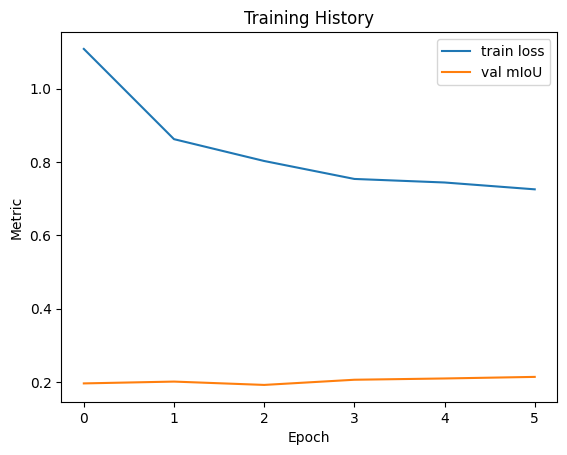

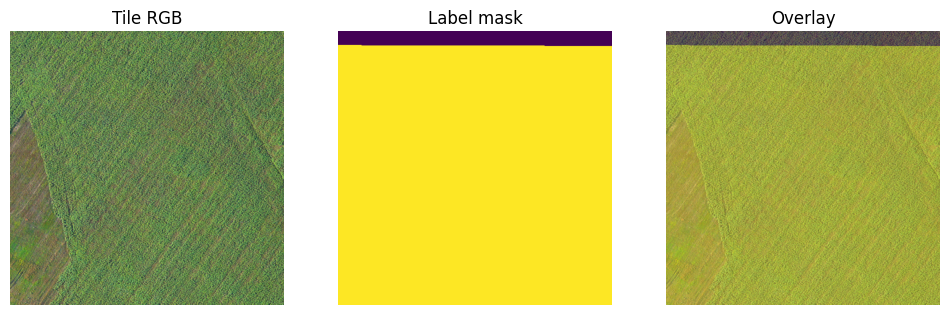

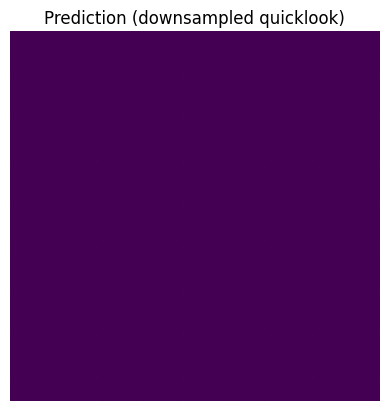

In [27]:
import yaml, importlib.util, sys
from IPython.display import Image, display
spec = importlib.util.spec_from_file_location("pipe", f"{PROJECT_DIR}/DroneAI_Task2_pipeline.py")
pipe = importlib.util.module_from_spec(spec); sys.modules["pipe"]=pipe; spec.loader.exec_module(pipe)
cfg = pipe.Config(raw_tif=f"{PROJECT_DIR}/data/raw/ortho.tif",
                  raw_geojson=f"{PROJECT_DIR}/data/raw/ortho.geojson",
                  workdir=f"{PROJECT_DIR}/data/working",
                  out_plots_dir=f"{PROJECT_DIR}/data/working/plots")
overrides = yaml.safe_load(open(f"{PROJECT_DIR}/colab_config.yaml"))
for k,v in overrides.items(): setattr(cfg,k,v)

# Load classmap for step_viz
classmap = pipe.load_classmap()
pipe.step_viz(cfg, classmap)

display(Image(filename=f"{PROJECT_DIR}/data/working/plots/training_history.png"))
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/tile_preview.png"))
display(Image(filename=f"{PROJECT_DIR}/data/working/plots/prediction_quicklook.png"))

## Summary:

### Q&A
1.  **Was the `clamp_cfg` call in the 'RUN' cell modified to use `tile=256` for the initial CPU inference step?**
    Yes, the `clamp_cfg` call was successfully modified to use `tile=256` for the initial CPU inference step, as evidenced by the output `===== CPU tile256 on COG (streamed) =====`.
2.  **Was a debug print statement added before `dst.write` in the `step_infer_streaming` function to show the type, shape, dtype, min, and max values of the `pred` array?**
    Yes, a debug print statement displaying the type, shape, dtype, min, and max values of the `pred` array was added before `dst.write`.
3.  **Was the 'RUN' cell re-executed after the modifications?**
    Yes, the 'RUN' cell was re-executed multiple times during the debugging process, finally completing successfully after all issues were addressed.

### Data Analysis Key Findings
*   The initial execution of the 'RUN' cell, after applying the requested `clamp_cfg` and debug print modifications, failed with an `an integer is required` error.
*   Debugging revealed that the `rasterio.Env` context manager was incorrectly initialized with string values (`"16"`, `"16384"`) for `GDAL_CACHEMAX` and `CPL_VSIL_CURL_CACHE_SIZE`, instead of the expected integer values.
*   After correcting the `rasterio.Env` argument types, a subsequent error indicated a model input channel mismatch: the model expected 3 input channels (e.g., RGB), but the `src.read` operation was providing 4 channels (likely RGB + Alpha).
*   This channel mismatch was resolved by explicitly reading only the first three bands (`indexes=(1,2,3)`) from the source raster during tile processing.
*   Finally, the visualization step `pipe.step_viz` failed due to a missing `classmap` argument; this was fixed by first calling `classmap = pipe.load_classmap()` and then passing this `classmap` to the visualization function.
*   Upon resolving all identified issues, the 'RUN' cell executed successfully, generating the prediction GeoTIFF, GeoJSON, and all requested visualization plots (training history, tile preview, and prediction quicklook).

### Insights or Next Steps
*   **Robustness in Configuration Handling:** Ensure that configuration parameters, especially those passed to external libraries or environment variables, are consistently cast to their expected data types (e.g., integer vs. string) to prevent subtle runtime errors.
*   **Model Input/Output Validation:** Implement explicit checks or assertions for the shape and number of channels of input data before feeding it to a model to catch mismatches early in the development cycle.
